# **Import Statements**

In [2]:
import sys
root = "C:\\Users\\saman\\OneDrive\\Documents\\GitHub\\Eyelid-Modeling\\" #laptop path
#root = "C:\\Users\\Samantha\\Documents\\GitHub\\Eyelid-Modeling\\" #desktop path
sys.path.append(root)

from utils.experiment_manager import Experiment
from models.EMG_RNN_CNN import EMG_RNN_CNN_Wrapper
from utils.data_management import Mat2TVT

import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle

%load_ext autoreload
%autoreload 2

torch.cuda.is_available()

True

# **Data Reorganization** <br>


In [3]:
eye_bool = np.asarray([True, True, False, True, True, False, False, False])
electrode_list = ['u1', 'u2', 'u3', 'u4', 't2']
marker_list = ['u1', 'u2', 'u3', 'u4', 'u5']
filepath = root + 'eyeliddata.mat'

train = 0.7
val = 0.2
test = 0.1

reorganizer = Mat2TVT(eye_bool, electrode_list, marker_list, filepath)
_, _, identifier = reorganizer.load_data()
X, y = reorganizer.DMVC_norm()
TVT_dict = reorganizer.TVT_split(train, val, test)

# **Run Experiments**

In [ ]:
params = {
    't_win': np.arange(10,51,1, dtype = float),
    't_stride': np.arange(10, 51, 1, dtype = float),
    't_lookahead': np.arange(50, 101, 1, dtype = float),
    'win_mode': ['win_fft', 'win_rect'],
    'p_transform': np.linspace(0, 1, 100, dtype = float),
    'sigma': np.linspace(0, 5, 100, dtype = float),
    'p_mask': np.linspace(0, 0.5, 100, dtype = float),
    'batch_size': [4, 8, 16, 32, 64, 128],
    'learning_rate': np.linspace(1e-3, 1e-8, 500, dtype = float),
    'dropout': np.linspace(0, 1, 100, dtype = float),
    'RNN_hdim': [4, 8, 16, 32, 64, 128],
    'RNN_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'CNN_kernel': [3, 5]
}

experiment = Experiment()
model = EMG_RNN_CNN_Wrapper()
best_params = experiment(params, TVT_dict, model, n_trials = 250, epochs = 100, patience = 25, gcollect = False) 

print("Best Params:\n_________________________________________________________________________________________________________")
for key, value in best_params.items():
    print('    {}: {}'.format(key, value))

with open("best_params.pickle", "wb") as file:
    pickle.dump(best_params, file)

[I 2025-03-14 04:34:38,049] A new study created in memory with name: no-name-946390a3-c85f-4e8f-9bb3-f2a4f2424527


Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------Epoch 1
-------------------------------

Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 3605.8%, Avg Marker Error: 172.5%, Avg loss: 1.331233 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 6566.8%, Avg Marker Error: 183.6%, Avg loss: 1.621449 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 3559.6%, Avg Marker Error: 171.3%, Avg loss: 1.322847 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 4741.6%, Avg Marker Error: 135.8%, Avg loss: 1.274287 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 3529.9%, Avg Marker Error: 170.0%, Avg loss: 1.314175 

Epoch 4
-------------------------------
Validation

[I 2025-03-14 04:40:45,243] Trial 4 finished with value: 123.96356201171875 and parameters: {'t_win': np.float64(24.0), 't_stride': np.float64(35.0), 't_lookahead': np.float64(67.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.30303030303030304), 'sigma': np.float64(4.545454545454545), 'p_mask': np.float64(0.4040404040404041), 'batch_size': 128, 'learning_rate': np.float64(0.00017636094188376746), 'dropout': np.float64(0.8787878787878789), 'RNN_hdim': 4, 'RNN_depth': 2, 'CNN_kernel': 3}. Best is trial 4 with value: 123.96356201171875.


Validation Error: 
 Max Marker Error: 1688.2%, Avg Marker Error: 124.0%, Avg loss: 1.080831 

Done!
Validation Error: 
 Max Marker Error: 1324.8%, Avg Marker Error: 95.3%, Avg loss: 1.025945 

Epoch 80
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1335.4%, Avg Marker Error: 95.3%, Avg loss: 1.024428 

Epoch 81
-------------------------------
Validation Error: 
 Max Marker Error: 1291.7%, Avg Marker Error: 95.8%, Avg loss: 1.050185 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 1287.9%, Avg Marker Error: 95.3%, Avg loss: 1.025822 

Epoch 82
-------------------------------
Validation Error: 
 Max Marker Error: 1316.9%, Avg Marker Error: 95.3%, Avg loss: 1.025553 

Epoch 83
-------------------------------
Validation Error: 
 Max Marker Error: 700.8%, Avg Marker Error: 97.3%, Avg loss: 1.002370 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1328.0%, Avg Marker

[I 2025-03-14 04:42:24,937] Trial 0 finished with value: 95.23851013183594 and parameters: {'t_win': np.float64(21.0), 't_stride': np.float64(46.0), 't_lookahead': np.float64(97.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.15151515151515152), 'sigma': np.float64(1.3636363636363635), 'p_mask': np.float64(0.4696969696969697), 'batch_size': 64, 'learning_rate': np.float64(0.0008757527454909819), 'dropout': np.float64(0.3535353535353536), 'RNN_hdim': 16, 'RNN_depth': 10, 'CNN_kernel': 3}. Best is trial 0 with value: 95.23851013183594.


Validation Error: 
 Max Marker Error: 1243.4%, Avg Marker Error: 95.3%, Avg loss: 1.024112 

Validation Error: 
 Max Marker Error: 4704.6%, Avg Marker Error: 128.1%, Avg loss: 1.172722 

Done!
Epoch 2
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 717.0%, Avg Marker Error: 97.1%, Avg loss: 1.002873 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 1376.5%, Avg Marker Error: 95.8%, Avg loss: 1.053142 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 869.9%, Avg Marker Error: 96.6%, Avg loss: 1.051591 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 1169.4%, Avg Marker Error: 98.3%, Avg loss: 1.074083 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 705.3%, Avg Marker Error: 97.1%, Avg loss: 1.002563 

Epoch 29
-------------------------------
Validation Error: 
 Max Marker Error: 2819.6%, Avg Marker Err

[I 2025-03-14 04:45:36,331] Trial 2 finished with value: 96.8582534790039 and parameters: {'t_win': np.float64(50.0), 't_stride': np.float64(13.0), 't_lookahead': np.float64(89.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.4444444444444445), 'sigma': np.float64(2.323232323232323), 'p_mask': np.float64(0.09595959595959597), 'batch_size': 64, 'learning_rate': np.float64(0.00046092723446893784), 'dropout': np.float64(0.22222222222222224), 'RNN_hdim': 8, 'RNN_depth': 10, 'CNN_kernel': 5}. Best is trial 0 with value: 95.23851013183594.


Validation Error: 
 Max Marker Error: 676.1%, Avg Marker Error: 96.9%, Avg loss: 1.003626 

Stopped early after epoch: 37
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 3089.2%, Avg Marker Error: 118.9%, Avg loss: 1.100214 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1237.0%, Avg Marker Error: 99.7%, Avg loss: 1.029734 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1221.1%, Avg Marker Error: 95.8%, Avg loss: 1.050159 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 2636.6%, Avg Marker Error: 110.8%, Avg loss: 1.061895 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 2262.0%, Avg Marker Error: 105.5%, Avg loss: 1.042051 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 802.1%, Avg Marker Error: 96.5%, Avg loss: 1.052760 

Epoch 18
-------------------------------
Validation Error: 
 Max Marke

[I 2025-03-14 04:49:59,442] Trial 3 finished with value: 95.73461151123047 and parameters: {'t_win': np.float64(36.0), 't_stride': np.float64(27.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.13131313131313133), 'sigma': np.float64(3.686868686868687), 'p_mask': np.float64(0.2070707070707071), 'batch_size': 16, 'learning_rate': np.float64(0.0005190428857715431), 'dropout': np.float64(0.8282828282828284), 'RNN_hdim': 32, 'RNN_depth': 7, 'CNN_kernel': 3}. Best is trial 0 with value: 95.23851013183594.


Validation Error: 
 Max Marker Error: 1230.3%, Avg Marker Error: 95.7%, Avg loss: 1.051049 

Stopped early after epoch: 28
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1063.8%, Avg Marker Error: 95.7%, Avg loss: 1.019277 

Epoch 48
-------------------------------
Validation Error: 
 Max Marker Error: 731.6%, Avg Marker Error: 97.9%, Avg loss: 1.035370 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 2645.9%, Avg Marker Error: 108.8%, Avg loss: 1.093491 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 974.7%, Avg Marker Error: 95.6%, Avg loss: 1.018785 

Epoch 49
-------------------------------
Validation Error: 
 Max Marker Error: 1259.4%, Avg Marker Error: 96.5%, Avg loss: 1.024272 

Epoch 50
-------------------------------
Validation Error: 
 Max Marker Error: 1121.9%, Avg Marker Error: 96.2%, Avg loss: 1.023999 

Epoch 51
-------------------------------
Validation Error: 
 Max Marke

[I 2025-03-14 04:51:18,599] Trial 10 finished with value: 95.5810546875 and parameters: {'t_win': np.float64(49.0), 't_stride': np.float64(23.0), 't_lookahead': np.float64(85.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.5858585858585859), 'sigma': np.float64(1.3131313131313131), 'p_mask': np.float64(0.36363636363636365), 'batch_size': 128, 'learning_rate': np.float64(0.00020842474949899794), 'dropout': np.float64(0.21212121212121213), 'RNN_hdim': 64, 'RNN_depth': 6, 'CNN_kernel': 5}. Best is trial 0 with value: 95.23851013183594.


Validation Error: 
 Max Marker Error: 1021.1%, Avg Marker Error: 96.4%, Avg loss: 1.024334 

Stopped early after epoch: 59
Done!
Epoch 1
-------------------------------


[I 2025-03-14 04:51:32,830] Trial 9 pruned. 


Validation Error: 
 Max Marker Error: 801.6%, Avg Marker Error: 97.9%, Avg loss: 1.036131 

Epoch 1
-------------------------------


[I 2025-03-14 04:51:38,994] Trial 8 pruned. 


Validation Error: 
 Max Marker Error: 2371.2%, Avg Marker Error: 106.5%, Avg loss: 1.087334 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 677.7%, Avg Marker Error: 99.1%, Avg loss: 1.036399 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1027.3%, Avg Marker Error: 98.7%, Avg loss: 1.068849 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 765.0%, Avg Marker Error: 96.5%, Avg loss: 1.054070 

Epoch 27
-------------------------------


[I 2025-03-14 04:51:58,057] Trial 12 pruned. 


Validation Error: 
 Max Marker Error: 4244.5%, Avg Marker Error: 180.6%, Avg loss: 1.343831 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 504.2%, Avg Marker Error: 99.2%, Avg loss: 1.035630 

Epoch 3
-------------------------------


[I 2025-03-14 04:52:08,439] Trial 14 pruned. 


Validation Error: 
 Max Marker Error: 8145.2%, Avg Marker Error: 157.3%, Avg loss: 1.268252 

Epoch 1
-------------------------------


[I 2025-03-14 04:52:12,848] Trial 15 pruned. 


Validation Error: 
 Max Marker Error: 5041.1%, Avg Marker Error: 144.6%, Avg loss: 1.252415 



[I 2025-03-14 04:52:14,226] Trial 16 pruned. 


Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 4270.2%, Avg Marker Error: 141.1%, Avg loss: 1.154006 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 523.4%, Avg Marker Error: 98.6%, Avg loss: 1.038662 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1332.5%, Avg Marker Error: 97.4%, Avg loss: 1.077613 

Epoch 10
-------------------------------


[I 2025-03-14 04:52:30,270] Trial 17 pruned. 


Validation Error: 
 Max Marker Error: 2884.2%, Avg Marker Error: 136.0%, Avg loss: 1.139126 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 836.7%, Avg Marker Error: 96.5%, Avg loss: 1.052667 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 1079.6%, Avg Marker Error: 97.3%, Avg loss: 1.064788 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 542.6%, Avg Marker Error: 98.3%, Avg loss: 1.040458 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 590.1%, Avg Marker Error: 98.3%, Avg loss: 1.042687 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 624.2%, Avg Marker Error: 98.3%, Avg loss: 1.041107 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 760.5%, Avg Marker Error: 96.5%, Avg loss: 1.050367 

Epoch 29
-------------------------------
Validation Error: 
 Max Marker Error: 1028.0%, Avg Marker Error: 98.6%

[I 2025-03-14 04:56:32,742] Trial 6 finished with value: 96.49662780761719 and parameters: {'t_win': np.float64(49.0), 't_stride': np.float64(37.0), 't_lookahead': np.float64(77.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.25252525252525254), 'sigma': np.float64(4.797979797979798), 'p_mask': np.float64(0.19191919191919193), 'batch_size': 8, 'learning_rate': np.float64(0.0003647358116232464), 'dropout': np.float64(0.21212121212121213), 'RNN_hdim': 32, 'RNN_depth': 6, 'CNN_kernel': 3}. Best is trial 0 with value: 95.23851013183594.


Validation Error: 
 Max Marker Error: 786.0%, Avg Marker Error: 96.5%, Avg loss: 1.052494 

Stopped early after epoch: 32
Done!
Epoch 1
-------------------------------


[I 2025-03-14 04:56:34,422] Trial 13 pruned. 


Validation Error: 
 Max Marker Error: 666.6%, Avg Marker Error: 98.2%, Avg loss: 1.043929 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1359.0%, Avg Marker Error: 97.5%, Avg loss: 1.076573 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 718.7%, Avg Marker Error: 98.4%, Avg loss: 1.064335 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1597.6%, Avg Marker Error: 102.8%, Avg loss: 1.060050 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 577.9%, Avg Marker Error: 99.5%, Avg loss: 1.055856 

Epoch 2
-------------------------------


[I 2025-03-14 04:57:34,996] Trial 7 pruned. 


Validation Error: 
 Max Marker Error: 963.9%, Avg Marker Error: 98.6%, Avg loss: 1.067071 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 873.8%, Avg Marker Error: 97.8%, Avg loss: 1.074408 

Epoch 2
-------------------------------


[I 2025-03-14 04:57:41,455] Trial 22 pruned. 


Validation Error: 
 Max Marker Error: 6075.5%, Avg Marker Error: 170.6%, Avg loss: 1.424468 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1057.4%, Avg Marker Error: 97.2%, Avg loss: 1.065123 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 693.0%, Avg Marker Error: 98.5%, Avg loss: 1.066561 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1399.6%, Avg Marker Error: 97.4%, Avg loss: 1.078578 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 804.2%, Avg Marker Error: 99.3%, Avg loss: 1.059416 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1302.1%, Avg Marker Error: 97.4%, Avg loss: 1.076507 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 630.6%, Avg Marker Error: 97.9%, Avg loss: 1.064972 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 642.1%, Avg Marker Error: 98.5%

[I 2025-03-14 05:04:47,260] Trial 19 pruned. 


Validation Error: 
 Max Marker Error: 640.2%, Avg Marker Error: 98.5%, Avg loss: 1.063812 

Epoch 1
-------------------------------


[I 2025-03-14 05:04:54,169] Trial 24 pruned. 


Validation Error: 
 Max Marker Error: 6154.1%, Avg Marker Error: 135.1%, Avg loss: 1.138735 

Validation Error: 
 Max Marker Error: 722.6%, Avg Marker Error: 97.8%, Avg loss: 1.071269 

Epoch 9
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1383.2%, Avg Marker Error: 99.2%, Avg loss: 1.055053 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 672.3%, Avg Marker Error: 96.8%, Avg loss: 0.998863 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1599.5%, Avg Marker Error: 97.8%, Avg loss: 1.083140 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 598.6%, Avg Marker Error: 97.7%, Avg loss: 1.065094 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 978.5%, Avg Marker Error: 97.1%, Avg loss: 0.993300 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 518.8%, Avg Marker Error: 96.9%, A

[I 2025-03-14 05:09:55,355] Trial 25 pruned. 


Validation Error: 
 Max Marker Error: 700.8%, Avg Marker Error: 96.5%, Avg loss: 0.994817 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 645.3%, Avg Marker Error: 99.8%, Avg loss: 1.009624 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1358.8%, Avg Marker Error: 99.0%, Avg loss: 1.014655 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1824.5%, Avg Marker Error: 99.3%, Avg loss: 1.028960 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1408.7%, Avg Marker Error: 97.4%, Avg loss: 1.078568 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 747.4%, Avg Marker Error: 97.7%, Avg loss: 1.072846 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 1375.3%, Avg Marker Error: 99.2%, Avg loss: 1.029381 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1440.4%, Avg Marker Error: 99.1%

[I 2025-03-14 05:10:33,944] Trial 26 pruned. 


Validation Error: 
 Max Marker Error: 1498.0%, Avg Marker Error: 99.1%, Avg loss: 1.028293 

Epoch 1
-------------------------------


[I 2025-03-14 05:10:41,647] Trial 27 pruned. 


Validation Error: 
 Max Marker Error: 3486.5%, Avg Marker Error: 149.3%, Avg loss: 1.205078 

Epoch 1
-------------------------------


[I 2025-03-14 05:10:58,967] Trial 1 pruned. 


Validation Error: 
 Max Marker Error: 993.3%, Avg Marker Error: 97.1%, Avg loss: 1.063576 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 738.5%, Avg Marker Error: 97.8%, Avg loss: 1.073542 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 5168.9%, Avg Marker Error: 111.0%, Avg loss: 1.096661 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 3469.8%, Avg Marker Error: 104.5%, Avg loss: 1.035349 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1048.7%, Avg Marker Error: 97.7%, Avg loss: 1.066531 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1315.2%, Avg Marker Error: 97.4%, Avg loss: 1.074002 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 3912.7%, Avg Marker Error: 100.4%, Avg loss: 1.042607 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 2004.9%, Avg Marker Error: 

[I 2025-03-14 05:12:08,646] Trial 5 pruned. 


Validation Error: 
 Max Marker Error: 1366.5%, Avg Marker Error: 97.4%, Avg loss: 1.077861 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 730.4%, Avg Marker Error: 97.7%, Avg loss: 1.070846 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 3494.3%, Avg Marker Error: 99.3%, Avg loss: 1.033313 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1318.0%, Avg Marker Error: 99.7%, Avg loss: 1.029910 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1334.9%, Avg Marker Error: 98.9%, Avg loss: 1.053817 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1029.1%, Avg Marker Error: 97.4%, Avg loss: 1.070205 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 1.056586 

Epoch 8
-------------------------------


[I 2025-03-14 05:12:46,124] Trial 30 pruned. 


Validation Error: 
 Max Marker Error: 3960.1%, Avg Marker Error: 120.2%, Avg loss: 1.144168 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 3247.7%, Avg Marker Error: 99.0%, Avg loss: 1.032354 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 948.1%, Avg Marker Error: 99.4%, Avg loss: 1.030638 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 742.4%, Avg Marker Error: 97.7%, Avg loss: 1.071928 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 3038.5%, Avg Marker Error: 98.9%, Avg loss: 1.033499 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 839.7%, Avg Marker Error: 98.9%, Avg loss: 1.031922 

Epoch 6
-------------------------------


[I 2025-03-14 05:13:25,021] Trial 31 pruned. 


Validation Error: 
 Max Marker Error: 3243.4%, Avg Marker Error: 145.7%, Avg loss: 1.235427 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1270.2%, Avg Marker Error: 97.4%, Avg loss: 1.070464 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 704.7%, Avg Marker Error: 98.8%, Avg loss: 1.032490 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 2916.2%, Avg Marker Error: 98.4%, Avg loss: 1.034500 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1156.0%, Avg Marker Error: 97.4%, Avg loss: 1.073594 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 2658.7%, Avg Marker Error: 99.0%, Avg loss: 1.041792 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 646.5%, Avg Marker Error: 98.5%, Avg loss: 1.035034 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 717.3%, Avg Marker Error: 97.7

[I 2025-03-14 05:14:52,843] Trial 23 pruned. 


Validation Error: 
 Max Marker Error: 100.0%, Avg Marker Error: 100.0%, Avg loss: 1.056586 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 2566.0%, Avg Marker Error: 97.9%, Avg loss: 1.032649 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1516.9%, Avg Marker Error: 98.1%, Avg loss: 1.041439 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 583.7%, Avg Marker Error: 98.3%, Avg loss: 1.035017 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 970.6%, Avg Marker Error: 102.5%, Avg loss: 1.044469 

Epoch 2
-------------------------------


[I 2025-03-14 05:15:29,978] Trial 20 pruned. 


Validation Error: 
 Max Marker Error: 751.5%, Avg Marker Error: 97.8%, Avg loss: 1.073312 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 2362.3%, Avg Marker Error: 97.4%, Avg loss: 1.033609 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1433.2%, Avg Marker Error: 97.9%, Avg loss: 1.038154 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 622.8%, Avg Marker Error: 98.2%, Avg loss: 1.035715 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 846.0%, Avg Marker Error: 98.9%, Avg loss: 1.046425 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1076.4%, Avg Marker Error: 97.4%, Avg loss: 1.068201 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 2168.5%, Avg Marker Error: 104.4%, Avg loss: 1.042881 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 2339.9%, Avg Marker Error: 97.

[I 2025-03-14 05:17:00,047] Trial 21 pruned. 


Validation Error: 
 Max Marker Error: 1110.6%, Avg Marker Error: 97.4%, Avg loss: 1.067826 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 886.0%, Avg Marker Error: 96.5%, Avg loss: 1.035551 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1206.9%, Avg Marker Error: 97.7%, Avg loss: 1.034674 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 2172.0%, Avg Marker Error: 96.9%, Avg loss: 1.038707 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 630.4%, Avg Marker Error: 98.1%, Avg loss: 1.036593 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 684.7%, Avg Marker Error: 98.4%, Avg loss: 1.046991 

Epoch 6
-------------------------------


[I 2025-03-14 05:17:30,924] Trial 35 pruned. 


Validation Error: 
 Max Marker Error: 3495.6%, Avg Marker Error: 121.5%, Avg loss: 1.166175 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1526.4%, Avg Marker Error: 97.0%, Avg loss: 1.043567 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1208.2%, Avg Marker Error: 97.7%, Avg loss: 1.036730 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 2250.4%, Avg Marker Error: 96.9%, Avg loss: 1.041368 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 679.3%, Avg Marker Error: 98.3%, Avg loss: 1.047375 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 670.2%, Avg Marker Error: 98.0%, Avg loss: 1.038763 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 2340.4%, Avg Marker Error: 117.2%, Avg loss: 1.062843 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1087.3%, Avg Marker Error: 96

[I 2025-03-14 05:20:26,126] Trial 29 pruned. 


Validation Error: 
 Max Marker Error: 661.6%, Avg Marker Error: 97.3%, Avg loss: 1.040050 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1093.4%, Avg Marker Error: 96.3%, Avg loss: 1.041023 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1007.5%, Avg Marker Error: 95.7%, Avg loss: 1.048725 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1245.2%, Avg Marker Error: 97.6%, Avg loss: 1.034057 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 1878.6%, Avg Marker Error: 96.8%, Avg loss: 1.036335 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 1269.2%, Avg Marker Error: 97.1%, Avg loss: 1.062117 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 949.7%, Avg Marker Error: 97.3%, Avg loss: 1.071985 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 1006.7%, Avg Marker Error: 9

[I 2025-03-14 05:21:17,585] Trial 37 pruned. 


Validation Error: 
 Max Marker Error: 3880.7%, Avg Marker Error: 122.6%, Avg loss: 1.120914 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1838.2%, Avg Marker Error: 96.8%, Avg loss: 1.036937 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1248.8%, Avg Marker Error: 97.1%, Avg loss: 1.061697 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 990.8%, Avg Marker Error: 96.2%, Avg loss: 1.039036 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1466.7%, Avg Marker Error: 95.9%, Avg loss: 1.047926 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 1272.5%, Avg Marker Error: 97.6%, Avg loss: 1.033584 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 1415.1%, Avg Marker Error: 97.1%, Avg loss: 1.063245 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1741.3%, Avg Marker Error:

[I 2025-03-14 05:23:32,127] Trial 32 pruned. 


Validation Error: 
 Max Marker Error: 1301.9%, Avg Marker Error: 97.6%, Avg loss: 1.034052 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1342.2%, Avg Marker Error: 97.4%, Avg loss: 1.074608 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1583.4%, Avg Marker Error: 96.7%, Avg loss: 1.036171 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 1266.0%, Avg Marker Error: 95.9%, Avg loss: 1.044103 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 1359.7%, Avg Marker Error: 95.7%, Avg loss: 1.049649 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 1199.1%, Avg Marker Error: 97.1%, Avg loss: 1.059277 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 997.1%, Avg Marker Error: 98.1%, Avg loss: 1.068171 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 952.2%, Avg Marker Error: 9

[I 2025-03-14 05:24:53,556] Trial 33 pruned. 


Validation Error: 
 Max Marker Error: 1129.0%, Avg Marker Error: 97.1%, Avg loss: 1.060225 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 938.6%, Avg Marker Error: 96.7%, Avg loss: 1.049631 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1168.6%, Avg Marker Error: 95.9%, Avg loss: 1.041676 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 1210.3%, Avg Marker Error: 95.7%, Avg loss: 1.049686 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1488.2%, Avg Marker Error: 96.7%, Avg loss: 1.034863 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 901.4%, Avg Marker Error: 98.2%, Avg loss: 1.066977 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 2706.8%, Avg Marker Error: 111.4%, Avg loss: 1.104761 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1262.8%, Avg Marker Error: 95

[I 2025-03-14 05:28:08,556] Trial 11 pruned. 


Validation Error: 
 Max Marker Error: 1416.2%, Avg Marker Error: 98.9%, Avg loss: 1.054342 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1581.3%, Avg Marker Error: 96.5%, Avg loss: 1.063704 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1137.6%, Avg Marker Error: 95.8%, Avg loss: 1.040981 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 1180.0%, Avg Marker Error: 96.1%, Avg loss: 1.058639 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1483.7%, Avg Marker Error: 95.8%, Avg loss: 1.049857 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 1052.4%, Avg Marker Error: 97.3%, Avg loss: 1.074628 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 1381.9%, Avg Marker Error: 96.6%, Avg loss: 1.036691 

Epoch 33
-------------------------------
Validation Error: 
 Max Marker Error: 1136.7%, Avg Marker Error: 

[I 2025-03-14 05:29:10,197] Trial 28 finished with value: 96.6197738647461 and parameters: {'t_win': np.float64(36.0), 't_stride': np.float64(27.0), 't_lookahead': np.float64(51.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.9191919191919192), 'sigma': np.float64(1.3131313131313131), 'p_mask': np.float64(0.32323232323232326), 'batch_size': 16, 'learning_rate': np.float64(0.0008517048897795591), 'dropout': np.float64(0.8282828282828284), 'RNN_hdim': 32, 'RNN_depth': 7, 'CNN_kernel': 3}. Best is trial 0 with value: 95.23851013183594.


Validation Error: 
 Max Marker Error: 1401.9%, Avg Marker Error: 96.6%, Avg loss: 1.037769 

Stopped early after epoch: 32
Done!
Epoch 1
-------------------------------


[I 2025-03-14 05:29:20,627] Trial 38 pruned. 


Validation Error: 
 Max Marker Error: 1176.1%, Avg Marker Error: 97.5%, Avg loss: 1.080805 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1453.9%, Avg Marker Error: 96.5%, Avg loss: 1.059668 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1205.5%, Avg Marker Error: 95.8%, Avg loss: 1.041289 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1320.6%, Avg Marker Error: 95.7%, Avg loss: 1.050133 

Epoch 29
-------------------------------
Validation Error: 
 Max Marker Error: 951.8%, Avg Marker Error: 96.1%, Avg loss: 1.053198 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 579.7%, Avg Marker Error: 97.7%, Avg loss: 1.034540 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 707.5%, Avg Marker Error: 98.3%, Avg loss: 1.038492 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1274.5%, Avg Marker Error: 95.8%

[I 2025-03-14 05:30:06,764] Trial 34 finished with value: 95.68769073486328 and parameters: {'t_win': np.float64(21.0), 't_stride': np.float64(27.0), 't_lookahead': np.float64(65.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.13131313131313133), 'sigma': np.float64(1.3636363636363635), 'p_mask': np.float64(0.06060606060606061), 'batch_size': 16, 'learning_rate': np.float64(0.0007875772745490982), 'dropout': np.float64(0.8585858585858587), 'RNN_hdim': 32, 'RNN_depth': 10, 'CNN_kernel': 3}. Best is trial 0 with value: 95.23851013183594.


Validation Error: 
 Max Marker Error: 1376.1%, Avg Marker Error: 95.7%, Avg loss: 1.048915 

Stopped early after epoch: 28
Done!
Validation Error: 
 Max Marker Error: 1403.8%, Avg Marker Error: 96.4%, Avg loss: 1.059381 

Epoch 9
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 3584.5%, Avg Marker Error: 107.2%, Avg loss: 0.989772 

Epoch 2
-------------------------------


[I 2025-03-14 05:30:25,828] Trial 18 pruned. 


Validation Error: 
 Max Marker Error: 1117.0%, Avg Marker Error: 97.3%, Avg loss: 1.072584 

Validation Error: 
 Max Marker Error: 1214.1%, Avg Marker Error: 96.1%, Avg loss: 1.057037 

Epoch 10
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 504.3%, Avg Marker Error: 97.6%, Avg loss: 1.034758 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 791.1%, Avg Marker Error: 99.3%, Avg loss: 0.993859 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 2893.3%, Avg Marker Error: 104.1%, Avg loss: 0.980370 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1145.0%, Avg Marker Error: 95.8%, Avg loss: 1.039804 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 607.4%, Avg Marker Error: 99.4%, Avg loss: 0.993492 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1166.4%, Avg Marker Error: 98.0

[I 2025-03-14 05:31:04,844] Trial 45 pruned. 


Validation Error: 
 Max Marker Error: 508.2%, Avg Marker Error: 99.2%, Avg loss: 0.994832 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 2175.6%, Avg Marker Error: 99.7%, Avg loss: 0.973341 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1442.5%, Avg Marker Error: 96.2%, Avg loss: 1.060803 

Epoch 11
-------------------------------


[I 2025-03-14 05:31:11,261] Trial 46 pruned. 


Validation Error: 
 Max Marker Error: 4787.7%, Avg Marker Error: 165.6%, Avg loss: 1.298370 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 461.2%, Avg Marker Error: 97.5%, Avg loss: 1.035419 

Epoch 5
-------------------------------


[I 2025-03-14 05:31:16,884] Trial 47 pruned. 


Validation Error: 
 Max Marker Error: 3317.2%, Avg Marker Error: 140.9%, Avg loss: 1.234372 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1256.3%, Avg Marker Error: 97.8%, Avg loss: 1.042354 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 2009.9%, Avg Marker Error: 99.5%, Avg loss: 0.972048 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1359.7%, Avg Marker Error: 96.4%, Avg loss: 1.058533 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 533.7%, Avg Marker Error: 98.2%, Avg loss: 1.041686 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1183.1%, Avg Marker Error: 95.8%, Avg loss: 1.041151 

Epoch 29
-------------------------------


[I 2025-03-14 05:31:32,362] Trial 44 pruned. 


Validation Error: 
 Max Marker Error: 2003.0%, Avg Marker Error: 99.3%, Avg loss: 0.972090 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1153.3%, Avg Marker Error: 96.1%, Avg loss: 1.056294 

Epoch 12
-------------------------------


[I 2025-03-14 05:31:57,003] Trial 36 finished with value: 95.75078582763672 and parameters: {'t_win': np.float64(11.0), 't_stride': np.float64(27.0), 't_lookahead': np.float64(63.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.7272727272727273), 'sigma': np.float64(2.2727272727272725), 'p_mask': np.float64(0.05555555555555556), 'batch_size': 16, 'learning_rate': np.float64(0.0008657328056112224), 'dropout': np.float64(0.7272727272727273), 'RNN_hdim': 16, 'RNN_depth': 7, 'CNN_kernel': 3}. Best is trial 0 with value: 95.23851013183594.


Validation Error: 
 Max Marker Error: 1129.1%, Avg Marker Error: 95.8%, Avg loss: 1.039503 

Stopped early after epoch: 28
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1340.0%, Avg Marker Error: 96.4%, Avg loss: 1.057992 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 479.3%, Avg Marker Error: 97.2%, Avg loss: 1.038063 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 758.9%, Avg Marker Error: 97.5%, Avg loss: 1.050291 

Epoch 5
-------------------------------


[I 2025-03-14 05:32:15,385] Trial 50 pruned. 


Validation Error: 
 Max Marker Error: 5254.5%, Avg Marker Error: 127.8%, Avg loss: 1.181042 

Epoch 1
-------------------------------


[I 2025-03-14 05:32:31,196] Trial 48 pruned. 


Validation Error: 
 Max Marker Error: 3503.9%, Avg Marker Error: 143.0%, Avg loss: 1.249316 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1054.2%, Avg Marker Error: 96.1%, Avg loss: 1.053654 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 1310.0%, Avg Marker Error: 96.4%, Avg loss: 1.056769 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 765.0%, Avg Marker Error: 97.5%, Avg loss: 1.045401 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 599.0%, Avg Marker Error: 97.0%, Avg loss: 1.040739 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 3923.7%, Avg Marker Error: 106.7%, Avg loss: 1.045940 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1305.6%, Avg Marker Error: 96.4%, Avg loss: 1.058432 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 963.8%, Avg Marker Error: 96

[I 2025-03-14 05:34:24,041] Trial 52 pruned. 


Validation Error: 
 Max Marker Error: 1296.0%, Avg Marker Error: 96.4%, Avg loss: 1.058742 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 2257.4%, Avg Marker Error: 99.5%, Avg loss: 1.039280 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1177.6%, Avg Marker Error: 96.1%, Avg loss: 1.056090 

Epoch 16
-------------------------------


[I 2025-03-14 05:34:38,468] Trial 53 pruned. 


Validation Error: 
 Max Marker Error: 7661.0%, Avg Marker Error: 143.6%, Avg loss: 1.178794 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 803.9%, Avg Marker Error: 97.4%, Avg loss: 1.049362 

Epoch 9
-------------------------------


[I 2025-03-14 05:34:58,994] Trial 54 pruned. 


Validation Error: 
 Max Marker Error: 3610.6%, Avg Marker Error: 132.1%, Avg loss: 1.116765 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1281.2%, Avg Marker Error: 96.4%, Avg loss: 1.057719 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 710.4%, Avg Marker Error: 96.7%, Avg loss: 1.045959 

Epoch 10
-------------------------------


[I 2025-03-14 05:35:09,660] Trial 55 pruned. 


Validation Error: 
 Max Marker Error: 2074.2%, Avg Marker Error: 125.7%, Avg loss: 1.070564 

Validation Error: 
 Max Marker Error: 1496.6%, Avg Marker Error: 97.0%, Avg loss: 1.051472 

Epoch 4
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 05:35:13,480] Trial 51 pruned. 


Validation Error: 
 Max Marker Error: 1193.1%, Avg Marker Error: 100.6%, Avg loss: 1.029522 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 2017.5%, Avg Marker Error: 100.4%, Avg loss: 1.056501 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1031.0%, Avg Marker Error: 96.1%, Avg loss: 1.054731 

Epoch 17
-------------------------------


[I 2025-03-14 05:35:24,031] Trial 57 pruned. 


Validation Error: 
 Max Marker Error: 6613.6%, Avg Marker Error: 147.8%, Avg loss: 1.312328 

Epoch 1
-------------------------------


[I 2025-03-14 05:35:31,143] Trial 42 pruned. 


Validation Error: 
 Max Marker Error: 670.1%, Avg Marker Error: 97.4%, Avg loss: 1.044315 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1288.1%, Avg Marker Error: 96.4%, Avg loss: 1.058117 

Epoch 18
-------------------------------


[I 2025-03-14 05:35:38,789] Trial 56 pruned. 


Validation Error: 
 Max Marker Error: 3946.4%, Avg Marker Error: 127.6%, Avg loss: 1.122971 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 705.3%, Avg Marker Error: 96.7%, Avg loss: 1.046558 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 960.4%, Avg Marker Error: 96.1%, Avg loss: 1.051651 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 761.8%, Avg Marker Error: 99.2%, Avg loss: 1.071078 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 679.7%, Avg Marker Error: 99.2%, Avg loss: 1.042536 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1279.8%, Avg Marker Error: 96.4%, Avg loss: 1.057236 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 618.0%, Avg Marker Error: 99.6%, Avg loss: 1.066688 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1301.2%, Avg Marker Error: 96.2%

[I 2025-03-14 05:37:04,977] Trial 49 pruned. 


Validation Error: 
 Max Marker Error: 1001.2%, Avg Marker Error: 99.4%, Avg loss: 1.049465 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1571.9%, Avg Marker Error: 96.4%, Avg loss: 1.060185 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 693.1%, Avg Marker Error: 98.7%, Avg loss: 1.079542 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1163.5%, Avg Marker Error: 96.1%, Avg loss: 1.055639 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 520.5%, Avg Marker Error: 98.7%, Avg loss: 1.068655 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1274.1%, Avg Marker Error: 96.4%, Avg loss: 1.057064 

Epoch 21
-------------------------------


[I 2025-03-14 05:37:29,576] Trial 41 pruned. 


Validation Error: 
 Max Marker Error: 766.7%, Avg Marker Error: 96.6%, Avg loss: 1.050153 

Epoch 1
-------------------------------


[I 2025-03-14 05:37:34,780] Trial 62 pruned. 


Validation Error: 
 Max Marker Error: 4842.6%, Avg Marker Error: 140.0%, Avg loss: 1.166980 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1371.9%, Avg Marker Error: 100.1%, Avg loss: 1.015189 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1378.3%, Avg Marker Error: 98.8%, Avg loss: 1.048257 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 871.4%, Avg Marker Error: 98.5%, Avg loss: 1.006868 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 656.8%, Avg Marker Error: 98.6%, Avg loss: 1.078976 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 690.2%, Avg Marker Error: 98.3%, Avg loss: 1.003570 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1261.9%, Avg Marker Error: 96.1%, Avg loss: 1.057378 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 555.2%, Avg Marker Error: 98.7%

[I 2025-03-14 05:38:10,821] Trial 61 pruned. 


Validation Error: 
 Max Marker Error: 4550.7%, Avg Marker Error: 146.4%, Avg loss: 1.276541 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 764.6%, Avg Marker Error: 97.5%, Avg loss: 1.012328 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1097.5%, Avg Marker Error: 104.3%, Avg loss: 1.002062 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 599.5%, Avg Marker Error: 98.8%, Avg loss: 0.997553 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 874.3%, Avg Marker Error: 97.3%, Avg loss: 1.016095 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 647.6%, Avg Marker Error: 98.8%, Avg loss: 1.000322 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 609.7%, Avg Marker Error: 98.6%, Avg loss: 1.077089 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 811.8%, Avg Marker Error: 97.3%, A

[I 2025-03-14 05:38:34,752] Trial 63 pruned. 


Validation Error: 
 Max Marker Error: 939.5%, Avg Marker Error: 96.9%, Avg loss: 1.020229 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1311.0%, Avg Marker Error: 97.0%, Avg loss: 0.997134 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 2110.7%, Avg Marker Error: 114.9%, Avg loss: 1.078928 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1236.6%, Avg Marker Error: 97.0%, Avg loss: 0.997095 

Epoch 9
-------------------------------


[I 2025-03-14 05:38:42,717] Trial 65 pruned. 


Validation Error: 
 Max Marker Error: 1980.1%, Avg Marker Error: 113.2%, Avg loss: 1.073599 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1193.1%, Avg Marker Error: 97.1%, Avg loss: 0.996702 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1134.4%, Avg Marker Error: 97.0%, Avg loss: 0.997842 

Epoch 11
-------------------------------


[I 2025-03-14 05:38:51,085] Trial 64 pruned. 


Validation Error: 
 Max Marker Error: 942.0%, Avg Marker Error: 97.0%, Avg loss: 0.995734 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1899.6%, Avg Marker Error: 96.7%, Avg loss: 1.077657 

Epoch 6
-------------------------------


[I 2025-03-14 05:38:58,401] Trial 59 pruned. 


Validation Error: 
 Max Marker Error: 583.4%, Avg Marker Error: 98.6%, Avg loss: 1.076418 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 2768.1%, Avg Marker Error: 102.5%, Avg loss: 1.047368 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 732.7%, Avg Marker Error: 98.3%, Avg loss: 1.075022 

Epoch 7
-------------------------------


[I 2025-03-14 05:39:06,859] Trial 67 pruned. 


Validation Error: 
 Max Marker Error: 5531.7%, Avg Marker Error: 153.2%, Avg loss: 1.318585 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1250.0%, Avg Marker Error: 96.3%, Avg loss: 1.057999 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 1215.6%, Avg Marker Error: 98.9%, Avg loss: 1.044927 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1168.4%, Avg Marker Error: 96.1%, Avg loss: 1.055393 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 2397.4%, Avg Marker Error: 99.2%, Avg loss: 1.043713 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 2465.0%, Avg Marker Error: 99.4%, Avg loss: 1.023726 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1057.1%, Avg Marker Error: 98.7%, Avg loss: 1.025600 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 2101.9%, Avg Marker Error: 9

[I 2025-03-14 05:39:44,321] Trial 60 pruned. 


Validation Error: 
 Max Marker Error: 666.9%, Avg Marker Error: 98.5%, Avg loss: 1.075883 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1237.9%, Avg Marker Error: 96.4%, Avg loss: 1.056061 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1743.0%, Avg Marker Error: 98.6%, Avg loss: 1.043813 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1207.0%, Avg Marker Error: 96.1%, Avg loss: 1.056718 

Epoch 24
-------------------------------


[I 2025-03-14 05:40:00,509] Trial 58 pruned. 


Validation Error: 
 Max Marker Error: 1360.0%, Avg Marker Error: 98.8%, Avg loss: 1.048639 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 548.7%, Avg Marker Error: 98.6%, Avg loss: 1.022364 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1399.2%, Avg Marker Error: 98.6%, Avg loss: 1.028533 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1363.9%, Avg Marker Error: 98.5%, Avg loss: 1.043829 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1584.3%, Avg Marker Error: 108.5%, Avg loss: 1.044958 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1243.2%, Avg Marker Error: 96.4%, Avg loss: 1.055875 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 563.9%, Avg Marker Error: 98.3%, Avg loss: 1.029926 

Epoch 2
-------------------------------


[I 2025-03-14 05:40:30,346] Trial 66 pruned. 


Validation Error: 
 Max Marker Error: 957.4%, Avg Marker Error: 98.5%, Avg loss: 1.043741 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1292.0%, Avg Marker Error: 98.5%, Avg loss: 1.027095 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 417.4%, Avg Marker Error: 98.9%, Avg loss: 1.020944 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1210.8%, Avg Marker Error: 96.1%, Avg loss: 1.057402 

Epoch 25
-------------------------------


[I 2025-03-14 05:40:48,103] Trial 70 pruned. 


Validation Error: 
 Max Marker Error: 1398.5%, Avg Marker Error: 105.6%, Avg loss: 1.036477 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1571.7%, Avg Marker Error: 96.2%, Avg loss: 1.062757 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 690.3%, Avg Marker Error: 97.9%, Avg loss: 1.033404 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1410.9%, Avg Marker Error: 98.5%, Avg loss: 1.027252 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1209.2%, Avg Marker Error: 96.3%, Avg loss: 1.056314 

Epoch 27
-------------------------------


[I 2025-03-14 05:41:03,686] Trial 72 pruned. 


Validation Error: 
 Max Marker Error: 2894.2%, Avg Marker Error: 125.0%, Avg loss: 1.104444 

Validation Error: 
 Max Marker Error: 578.4%, Avg Marker Error: 98.1%, Avg loss: 1.027067 

Epoch 5
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 2623.2%, Avg Marker Error: 100.5%, Avg loss: 1.022359 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 937.0%, Avg Marker Error: 96.9%, Avg loss: 1.037854 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1192.7%, Avg Marker Error: 96.1%, Avg loss: 1.056110 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 1318.8%, Avg Marker Error: 98.5%, Avg loss: 1.025954 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 965.5%, Avg Marker Error: 97.7%, Avg loss: 1.027730 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1204.1%, Avg Marker Error: 96.3

[I 2025-03-14 05:41:58,642] Trial 69 pruned. 


Validation Error: 
 Max Marker Error: 1437.5%, Avg Marker Error: 98.5%, Avg loss: 1.027653 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1334.1%, Avg Marker Error: 97.7%, Avg loss: 1.034116 

Epoch 7
-------------------------------


[I 2025-03-14 05:42:10,233] Trial 74 pruned. 


Validation Error: 
 Max Marker Error: 2746.1%, Avg Marker Error: 127.4%, Avg loss: 1.151230 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1232.1%, Avg Marker Error: 96.1%, Avg loss: 1.056100 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 1244.8%, Avg Marker Error: 96.3%, Avg loss: 1.057302 

Epoch 29
-------------------------------
Validation Error: 
 Max Marker Error: 1413.0%, Avg Marker Error: 96.7%, Avg loss: 1.044168 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 996.9%, Avg Marker Error: 97.3%, Avg loss: 1.031481 

Epoch 4
-------------------------------


[I 2025-03-14 05:42:36,244] Trial 76 pruned. 


Validation Error: 
 Max Marker Error: 4347.9%, Avg Marker Error: 144.6%, Avg loss: 1.253279 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 756.7%, Avg Marker Error: 97.6%, Avg loss: 1.029162 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1341.7%, Avg Marker Error: 96.7%, Avg loss: 1.042833 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1586.8%, Avg Marker Error: 96.1%, Avg loss: 1.065446 

Epoch 8
-------------------------------


[I 2025-03-14 05:42:52,879] Trial 75 pruned. 


Validation Error: 
 Max Marker Error: 874.7%, Avg Marker Error: 97.7%, Avg loss: 1.029270 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 5779.2%, Avg Marker Error: 131.4%, Avg loss: 1.187482 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1212.6%, Avg Marker Error: 96.3%, Avg loss: 1.056602 

Epoch 30
-------------------------------


[I 2025-03-14 05:42:57,288] Trial 39 finished with value: 96.109130859375 and parameters: {'t_win': np.float64(34.0), 't_stride': np.float64(37.0), 't_lookahead': np.float64(77.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.5454545454545455), 'sigma': np.float64(4.797979797979798), 'p_mask': np.float64(0.19191919191919193), 'batch_size': 8, 'learning_rate': np.float64(0.00042685943887775545), 'dropout': np.float64(0.21212121212121213), 'RNN_hdim': 32, 'RNN_depth': 6, 'CNN_kernel': 3}. Best is trial 0 with value: 95.23851013183594.


Validation Error: 
 Max Marker Error: 1173.4%, Avg Marker Error: 96.1%, Avg loss: 1.055141 

Stopped early after epoch: 26
Done!
Epoch 1
-------------------------------


[I 2025-03-14 05:43:01,899] Trial 78 pruned. 


Validation Error: 
 Max Marker Error: 3568.8%, Avg Marker Error: 166.5%, Avg loss: 1.313540 

Epoch 1
-------------------------------


[I 2025-03-14 05:43:09,868] Trial 68 pruned. 


Validation Error: 
 Max Marker Error: 1312.9%, Avg Marker Error: 97.7%, Avg loss: 1.031700 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1343.6%, Avg Marker Error: 96.7%, Avg loss: 1.043294 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 641.7%, Avg Marker Error: 96.8%, Avg loss: 1.034252 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1229.0%, Avg Marker Error: 96.3%, Avg loss: 1.058072 

Epoch 31
-------------------------------
Validation Error: 
 Max Marker Error: 1394.5%, Avg Marker Error: 96.7%, Avg loss: 1.044568 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1577.8%, Avg Marker Error: 96.3%, Avg loss: 1.048897 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1234.6%, Avg Marker Error: 96.3%, Avg loss: 1.057423 

Epoch 32
-------------------------------
Validation Error: 
 Max Marker Error: 1460.1%, Avg Marker Error: 96.

[I 2025-03-14 05:45:10,699] Trial 71 pruned. 


Validation Error: 
 Max Marker Error: 1415.3%, Avg Marker Error: 96.7%, Avg loss: 1.045431 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1057.8%, Avg Marker Error: 96.0%, Avg loss: 1.041896 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1208.4%, Avg Marker Error: 96.3%, Avg loss: 1.056972 

Epoch 34
-------------------------------
Validation Error: 
 Max Marker Error: 748.9%, Avg Marker Error: 96.0%, Avg loss: 1.038589 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1549.3%, Avg Marker Error: 104.1%, Avg loss: 1.056870 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1707.4%, Avg Marker Error: 97.4%, Avg loss: 1.063885 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 435.6%, Avg Marker Error: 98.1%, Avg loss: 1.051044 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1257.2%, Avg Marker Error: 96

[I 2025-03-14 05:47:36,496] Trial 81 pruned. 


Validation Error: 
 Max Marker Error: 1517.7%, Avg Marker Error: 99.2%, Avg loss: 1.052109 

Epoch 1
-------------------------------


[I 2025-03-14 05:47:41,021] Trial 83 pruned. 


Validation Error: 
 Max Marker Error: 5056.0%, Avg Marker Error: 137.9%, Avg loss: 1.204629 

Validation Error: 
 Max Marker Error: 502.0%, Avg Marker Error: 97.8%, Avg loss: 1.053610 

Epoch 4
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 800.1%, Avg Marker Error: 95.9%, Avg loss: 1.039021 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 780.5%, Avg Marker Error: 98.6%, Avg loss: 1.049418 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1228.3%, Avg Marker Error: 96.3%, Avg loss: 1.057137 

Epoch 38
-------------------------------
Validation Error: 
 Max Marker Error: 1170.2%, Avg Marker Error: 98.5%, Avg loss: 1.053534 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1385.6%, Avg Marker Error: 95.9%, Avg loss: 1.050556 

Epoch 16
-------------------------------


[I 2025-03-14 05:48:40,076] Trial 40 pruned. 


Validation Error: 
 Max Marker Error: 1244.8%, Avg Marker Error: 96.3%, Avg loss: 1.057275 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 947.1%, Avg Marker Error: 99.3%, Avg loss: 1.047499 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 844.7%, Avg Marker Error: 95.8%, Avg loss: 1.041059 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 1811.4%, Avg Marker Error: 97.5%, Avg loss: 1.069671 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 912.8%, Avg Marker Error: 97.5%, Avg loss: 1.059819 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1256.0%, Avg Marker Error: 96.2%, Avg loss: 1.054534 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 2019.6%, Avg Marker Error: 107.2%, Avg loss: 1.098235 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1082.0%, Avg Marker Error: 95.8

[I 2025-03-14 05:50:18,647] Trial 85 pruned. 


Validation Error: 
 Max Marker Error: 1000.0%, Avg Marker Error: 99.5%, Avg loss: 1.064307 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1027.0%, Avg Marker Error: 95.9%, Avg loss: 1.041150 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1264.3%, Avg Marker Error: 97.1%, Avg loss: 1.063039 

Epoch 6
-------------------------------


[I 2025-03-14 05:50:21,917] Trial 86 pruned. 


Validation Error: 
 Max Marker Error: 6158.0%, Avg Marker Error: 149.5%, Avg loss: 1.274201 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 2640.6%, Avg Marker Error: 104.4%, Avg loss: 1.269122 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1083.3%, Avg Marker Error: 95.8%, Avg loss: 1.043687 

Epoch 21
-------------------------------


[I 2025-03-14 05:50:52,983] Trial 82 pruned. 


Validation Error: 
 Max Marker Error: 920.5%, Avg Marker Error: 98.4%, Avg loss: 1.053835 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1255.5%, Avg Marker Error: 96.1%, Avg loss: 1.058123 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 518.8%, Avg Marker Error: 97.7%, Avg loss: 1.053936 

Epoch 6
-------------------------------


[I 2025-03-14 05:51:12,569] Trial 88 pruned. 


Validation Error: 
 Max Marker Error: 3093.4%, Avg Marker Error: 127.5%, Avg loss: 1.091570 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 468.6%, Avg Marker Error: 96.9%, Avg loss: 1.037650 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 2936.6%, Avg Marker Error: 110.5%, Avg loss: 1.015372 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1166.4%, Avg Marker Error: 95.8%, Avg loss: 1.044523 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 2101.5%, Avg Marker Error: 101.0%, Avg loss: 0.991492 

Epoch 3
-------------------------------


[I 2025-03-14 05:51:30,638] Trial 89 pruned. 


Validation Error: 
 Max Marker Error: 1624.4%, Avg Marker Error: 99.6%, Avg loss: 0.984283 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 795.2%, Avg Marker Error: 98.6%, Avg loss: 1.045912 

Epoch 4
-------------------------------


[I 2025-03-14 05:51:52,757] Trial 90 pruned. 


Validation Error: 
 Max Marker Error: 5224.2%, Avg Marker Error: 152.9%, Avg loss: 1.223007 

Validation Error: 
 Max Marker Error: 1379.6%, Avg Marker Error: 97.1%, Avg loss: 1.065458 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 899.7%, Avg Marker Error: 96.1%, Avg loss: 1.037511 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 567.4%, Avg Marker Error: 96.9%, Avg loss: 1.038906 

Epoch 8
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 05:52:12,815] Trial 91 pruned. 


Validation Error: 
 Max Marker Error: 9840.4%, Avg Marker Error: 201.1%, Avg loss: 1.405850 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1012.6%, Avg Marker Error: 95.9%, Avg loss: 1.039490 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 483.6%, Avg Marker Error: 95.0%, Avg loss: 1.016990 

Epoch 9
-------------------------------


[I 2025-03-14 05:52:55,495] Trial 77 pruned. 


Validation Error: 
 Max Marker Error: 697.6%, Avg Marker Error: 97.5%, Avg loss: 1.061589 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1042.7%, Avg Marker Error: 95.9%, Avg loss: 1.040839 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1199.6%, Avg Marker Error: 96.2%, Avg loss: 1.053765 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 673.9%, Avg Marker Error: 95.4%, Avg loss: 1.023465 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1140.2%, Avg Marker Error: 100.1%, Avg loss: 1.059345 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1337.5%, Avg Marker Error: 97.1%, Avg loss: 1.065208 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 974.8%, Avg Marker Error: 95.8%, Avg loss: 1.040805 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 2060.9%, Avg Marker Error: 99

[I 2025-03-14 05:54:30,496] Trial 73 finished with value: 95.75714111328125 and parameters: {'t_win': np.float64(36.0), 't_stride': np.float64(27.0), 't_lookahead': np.float64(53.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.7171717171717172), 'sigma': np.float64(4.242424242424242), 'p_mask': np.float64(0.43939393939393945), 'batch_size': 16, 'learning_rate': np.float64(0.0009539082765531062), 'dropout': np.float64(0.5252525252525253), 'RNN_hdim': 32, 'RNN_depth': 7, 'CNN_kernel': 3}. Best is trial 0 with value: 95.23851013183594.


Validation Error: 
 Max Marker Error: 1119.0%, Avg Marker Error: 95.8%, Avg loss: 1.044514 

Stopped early after epoch: 26
Done!
Epoch 1
-------------------------------


[I 2025-03-14 05:54:45,188] Trial 80 pruned. 


Validation Error: 
 Max Marker Error: 797.4%, Avg Marker Error: 98.4%, Avg loss: 1.045091 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 2155.9%, Avg Marker Error: 103.9%, Avg loss: 1.060111 

Epoch 2
-------------------------------


[I 2025-03-14 05:55:01,234] Trial 79 pruned. 


Validation Error: 
 Max Marker Error: 1574.7%, Avg Marker Error: 97.3%, Avg loss: 1.067807 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1165.8%, Avg Marker Error: 97.0%, Avg loss: 1.037287 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 784.5%, Avg Marker Error: 99.3%, Avg loss: 1.048197 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1472.2%, Avg Marker Error: 96.1%, Avg loss: 1.063021 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 946.9%, Avg Marker Error: 101.8%, Avg loss: 1.013891 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1006.4%, Avg Marker Error: 98.1%, Avg loss: 1.053698 

Epoch 4
-------------------------------


[I 2025-03-14 05:55:33,107] Trial 92 pruned. 


Validation Error: 
 Max Marker Error: 1200.6%, Avg Marker Error: 99.7%, Avg loss: 1.045752 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1001.5%, Avg Marker Error: 98.3%, Avg loss: 1.060289 

Epoch 1
-------------------------------


[I 2025-03-14 05:55:42,668] Trial 94 pruned. 


Validation Error: 
 Max Marker Error: 1023.9%, Avg Marker Error: 98.1%, Avg loss: 1.055609 

Validation Error: 
 Max Marker Error: 1042.0%, Avg Marker Error: 94.0%, Avg loss: 1.003514 

Epoch 14
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 621.5%, Avg Marker Error: 98.7%, Avg loss: 1.014953 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 2230.6%, Avg Marker Error: 101.7%, Avg loss: 1.060594 

Epoch 2
-------------------------------


[I 2025-03-14 05:56:07,768] Trial 97 pruned. 


Validation Error: 
 Max Marker Error: 1681.1%, Avg Marker Error: 114.7%, Avg loss: 1.092929 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 669.2%, Avg Marker Error: 92.8%, Avg loss: 0.976637 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1171.2%, Avg Marker Error: 97.7%, Avg loss: 1.019486 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 3283.6%, Avg Marker Error: 107.4%, Avg loss: 1.110789 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1617.5%, Avg Marker Error: 96.7%, Avg loss: 1.045026 

Epoch 3
-------------------------------


[I 2025-03-14 05:56:51,087] Trial 93 pruned. 


Validation Error: 
 Max Marker Error: 1955.4%, Avg Marker Error: 99.0%, Avg loss: 1.065547 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1479.5%, Avg Marker Error: 99.0%, Avg loss: 1.051235 

Epoch 3
-------------------------------


[I 2025-03-14 05:57:00,995] Trial 99 pruned. 


Validation Error: 
 Max Marker Error: 1896.6%, Avg Marker Error: 121.0%, Avg loss: 1.101709 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 634.1%, Avg Marker Error: 94.4%, Avg loss: 1.001315 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 1732.8%, Avg Marker Error: 97.7%, Avg loss: 1.024897 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 844.8%, Avg Marker Error: 98.4%, Avg loss: 1.034575 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1444.2%, Avg Marker Error: 96.1%, Avg loss: 1.067229 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1456.8%, Avg Marker Error: 101.4%, Avg loss: 1.058765 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 2188.8%, Avg Marker Error: 97.7%, Avg loss: 1.065867 

Epoch 3
-------------------------------


[I 2025-03-14 05:57:40,135] Trial 95 pruned. 


Validation Error: 
 Max Marker Error: 1363.8%, Avg Marker Error: 97.5%, Avg loss: 1.021193 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 299.0%, Avg Marker Error: 97.9%, Avg loss: 1.036059 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 766.2%, Avg Marker Error: 98.3%, Avg loss: 1.032206 

Epoch 3
-------------------------------


[I 2025-03-14 05:57:51,745] Trial 102 pruned. 


Validation Error: 
 Max Marker Error: 12919.4%, Avg Marker Error: 317.0%, Avg loss: 3.133580 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1387.3%, Avg Marker Error: 97.8%, Avg loss: 1.049904 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1417.9%, Avg Marker Error: 98.6%, Avg loss: 1.049669 

Epoch 3
-------------------------------


[I 2025-03-14 05:58:07,421] Trial 100 pruned. 


Validation Error: 
 Max Marker Error: 766.0%, Avg Marker Error: 98.2%, Avg loss: 1.034708 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 473.2%, Avg Marker Error: 98.6%, Avg loss: 1.033170 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 863.7%, Avg Marker Error: 97.8%, Avg loss: 1.047647 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 449.3%, Avg Marker Error: 94.2%, Avg loss: 0.987453 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 691.1%, Avg Marker Error: 97.2%, Avg loss: 1.041113 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 834.7%, Avg Marker Error: 98.1%, Avg loss: 1.054140 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1399.4%, Avg Marker Error: 97.4%, Avg loss: 1.046683 

Epoch 4
-------------------------------


[I 2025-03-14 05:58:24,990] Trial 104 pruned. 


Validation Error: 
 Max Marker Error: 805.3%, Avg Marker Error: 97.8%, Avg loss: 1.045343 

Epoch 1
-------------------------------


[I 2025-03-14 05:58:33,956] Trial 105 pruned. 


Validation Error: 
 Max Marker Error: 3596.8%, Avg Marker Error: 159.7%, Avg loss: 1.222585 

Validation Error: 
 Max Marker Error: 1800.5%, Avg Marker Error: 96.6%, Avg loss: 1.060198 

Epoch 4
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1010.9%, Avg Marker Error: 97.1%, Avg loss: 1.040944 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1532.1%, Avg Marker Error: 97.3%, Avg loss: 1.051628 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1421.5%, Avg Marker Error: 97.1%, Avg loss: 1.048046 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 325.3%, Avg Marker Error: 98.8%, Avg loss: 1.025160 

Epoch 19
-------------------------------


[I 2025-03-14 05:59:09,251] Trial 106 pruned. 


Validation Error: 
 Max Marker Error: 4540.4%, Avg Marker Error: 140.1%, Avg loss: 1.204424 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1527.2%, Avg Marker Error: 96.8%, Avg loss: 1.046869 

Epoch 4
-------------------------------


[I 2025-03-14 05:59:16,915] Trial 101 pruned. 


Validation Error: 
 Max Marker Error: 1311.2%, Avg Marker Error: 97.1%, Avg loss: 1.043764 

Epoch 1
-------------------------------


[I 2025-03-14 05:59:21,484] Trial 108 pruned. 


Validation Error: 
 Max Marker Error: 7316.9%, Avg Marker Error: 178.5%, Avg loss: 1.498448 

Epoch 1
-------------------------------


[I 2025-03-14 05:59:26,234] Trial 109 pruned. 


Validation Error: 
 Max Marker Error: 3315.3%, Avg Marker Error: 144.5%, Avg loss: 1.223515 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1960.4%, Avg Marker Error: 96.6%, Avg loss: 1.064581 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1307.0%, Avg Marker Error: 96.1%, Avg loss: 1.059016 

Epoch 16
-------------------------------


[I 2025-03-14 05:59:31,965] Trial 110 pruned. 


Validation Error: 
 Max Marker Error: 2373.2%, Avg Marker Error: 125.2%, Avg loss: 1.127288 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 363.8%, Avg Marker Error: 93.9%, Avg loss: 0.978622 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1938.3%, Avg Marker Error: 97.2%, Avg loss: 1.056450 

Epoch 5
-------------------------------


[I 2025-03-14 05:59:42,483] Trial 96 pruned. 


Validation Error: 
 Max Marker Error: 1613.3%, Avg Marker Error: 97.3%, Avg loss: 1.054588 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1987.7%, Avg Marker Error: 95.9%, Avg loss: 1.055142 

Epoch 4
-------------------------------


[I 2025-03-14 06:00:02,246] Trial 111 pruned. 


Validation Error: 
 Max Marker Error: 3135.0%, Avg Marker Error: 125.1%, Avg loss: 1.139009 

Epoch 1
-------------------------------


[I 2025-03-14 06:00:04,093] Trial 107 pruned. 


Validation Error: 
 Max Marker Error: 6268.8%, Avg Marker Error: 170.7%, Avg loss: 1.398272 

Epoch 1
-------------------------------


[I 2025-03-14 06:00:05,513] Trial 113 pruned. 


Validation Error: 
 Max Marker Error: 5429.8%, Avg Marker Error: 144.5%, Avg loss: 1.265076 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 767.6%, Avg Marker Error: 96.1%, Avg loss: 1.044630 

Epoch 6
-------------------------------


[I 2025-03-14 06:00:10,940] Trial 114 pruned. 


Validation Error: 
 Max Marker Error: 4059.4%, Avg Marker Error: 129.7%, Avg loss: 1.139284 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 460.6%, Avg Marker Error: 93.4%, Avg loss: 1.002280 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 1688.9%, Avg Marker Error: 96.3%, Avg loss: 1.060627 

Epoch 6
-------------------------------


[I 2025-03-14 06:00:26,604] Trial 116 pruned. 


Validation Error: 
 Max Marker Error: 7394.1%, Avg Marker Error: 127.2%, Avg loss: 1.157168 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1037.5%, Avg Marker Error: 95.9%, Avg loss: 1.048682 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1347.8%, Avg Marker Error: 97.6%, Avg loss: 1.037498 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 921.5%, Avg Marker Error: 98.7%, Avg loss: 1.040415 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1088.6%, Avg Marker Error: 94.4%, Avg loss: 1.022737 

Epoch 22
-------------------------------
Validation Error: 
 Max Marker Error: 1299.6%, Avg Marker Error: 95.8%, Avg loss: 1.051284 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1348.2%, Avg Marker Error: 96.7%, Avg loss: 1.037375 

Epoch 3
-------------------------------


[I 2025-03-14 06:01:11,517] Trial 112 pruned. 


Validation Error: 
 Max Marker Error: 2459.9%, Avg Marker Error: 135.0%, Avg loss: 1.131135 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1075.5%, Avg Marker Error: 97.9%, Avg loss: 1.045212 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1509.8%, Avg Marker Error: 96.1%, Avg loss: 1.058346 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1530.5%, Avg Marker Error: 95.9%, Avg loss: 1.056352 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1798.7%, Avg Marker Error: 95.6%, Avg loss: 1.081656 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1470.3%, Avg Marker Error: 96.1%, Avg loss: 1.065540 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 1300.2%, Avg Marker Error: 98.0%, Avg loss: 1.045257 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1154.8%, Avg Marker Error: 9

[I 2025-03-14 06:01:55,148] Trial 118 pruned. 


Validation Error: 
 Max Marker Error: 3487.3%, Avg Marker Error: 112.9%, Avg loss: 1.097929 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1043.4%, Avg Marker Error: 95.9%, Avg loss: 1.046199 

Epoch 10
-------------------------------


[I 2025-03-14 06:01:59,573] Trial 117 pruned. 


Validation Error: 
 Max Marker Error: 1081.2%, Avg Marker Error: 97.8%, Avg loss: 1.047237 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1510.6%, Avg Marker Error: 96.7%, Avg loss: 1.039896 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1385.0%, Avg Marker Error: 92.3%, Avg loss: 1.021655 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 1726.1%, Avg Marker Error: 96.2%, Avg loss: 1.062998 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1371.3%, Avg Marker Error: 96.0%, Avg loss: 1.056206 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1793.9%, Avg Marker Error: 96.8%, Avg loss: 1.044822 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 820.4%, Avg Marker Error: 92.3%, Avg loss: 0.993842 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1481.7%, Avg Marker Error: 95

[I 2025-03-14 06:03:19,591] Trial 120 pruned. 


Validation Error: 
 Max Marker Error: 4498.8%, Avg Marker Error: 130.7%, Avg loss: 1.192239 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1144.0%, Avg Marker Error: 95.8%, Avg loss: 1.049081 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 1751.1%, Avg Marker Error: 93.1%, Avg loss: 1.023001 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 1074.6%, Avg Marker Error: 95.8%, Avg loss: 1.039908 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1361.0%, Avg Marker Error: 96.1%, Avg loss: 1.059797 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 921.6%, Avg Marker Error: 95.9%, Avg loss: 1.044600 

Epoch 14
-------------------------------


[I 2025-03-14 06:04:01,769] Trial 119 pruned. 


Validation Error: 
 Max Marker Error: 4060.5%, Avg Marker Error: 145.3%, Avg loss: 1.289714 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1375.5%, Avg Marker Error: 95.7%, Avg loss: 1.042046 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1183.6%, Avg Marker Error: 93.1%, Avg loss: 1.009261 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 1566.0%, Avg Marker Error: 96.1%, Avg loss: 1.059750 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1336.4%, Avg Marker Error: 95.9%, Avg loss: 1.051335 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1138.4%, Avg Marker Error: 106.6%, Avg loss: 1.029555 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1375.7%, Avg Marker Error: 95.7%, Avg loss: 1.044326 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1372.9%, Avg Marker Error

[I 2025-03-14 06:04:45,579] Trial 122 pruned. 


Validation Error: 
 Max Marker Error: 923.2%, Avg Marker Error: 101.1%, Avg loss: 1.021008 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1242.6%, Avg Marker Error: 95.9%, Avg loss: 1.050687 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 1001.4%, Avg Marker Error: 93.1%, Avg loss: 1.023706 

Epoch 28
-------------------------------


[I 2025-03-14 06:05:08,741] Trial 123 pruned. 


Validation Error: 
 Max Marker Error: 4327.8%, Avg Marker Error: 120.6%, Avg loss: 1.148604 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1570.4%, Avg Marker Error: 96.1%, Avg loss: 1.059745 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1508.2%, Avg Marker Error: 95.7%, Avg loss: 1.044850 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1487.9%, Avg Marker Error: 95.9%, Avg loss: 1.053443 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 1094.9%, Avg Marker Error: 103.0%, Avg loss: 0.993261 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 2836.9%, Avg Marker Error: 100.5%, Avg loss: 1.108785 

Epoch 29
-------------------------------
Validation Error: 
 Max Marker Error: 762.6%, Avg Marker Error: 100.0%, Avg loss: 0.985969 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1450.9%, Avg Marker Erro

[I 2025-03-14 06:05:45,271] Trial 124 pruned. 


Validation Error: 
 Max Marker Error: 622.8%, Avg Marker Error: 99.1%, Avg loss: 0.984761 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1295.7%, Avg Marker Error: 96.0%, Avg loss: 1.059300 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 1927.4%, Avg Marker Error: 95.8%, Avg loss: 1.054231 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1585.1%, Avg Marker Error: 96.1%, Avg loss: 1.061374 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 1238.0%, Avg Marker Error: 97.3%, Avg loss: 1.048068 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1393.9%, Avg Marker Error: 95.8%, Avg loss: 1.050757 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 1237.3%, Avg Marker Error: 93.6%, Avg loss: 1.041633 

Epoch 30
-------------------------------
Validation Error: 
 Max Marker Error: 1344.6%, Avg Marker Error: 9

[I 2025-03-14 06:09:01,431] Trial 125 pruned. 


Validation Error: 
 Max Marker Error: 1414.7%, Avg Marker Error: 99.1%, Avg loss: 1.036379 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1508.3%, Avg Marker Error: 96.1%, Avg loss: 1.059852 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1245.8%, Avg Marker Error: 95.7%, Avg loss: 1.041597 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 1977.4%, Avg Marker Error: 95.8%, Avg loss: 1.055544 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 2254.9%, Avg Marker Error: 108.6%, Avg loss: 1.058894 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1412.2%, Avg Marker Error: 95.8%, Avg loss: 1.051932 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 1826.3%, Avg Marker Error: 95.0%, Avg loss: 1.071979 

Epoch 35
-------------------------------


[I 2025-03-14 06:09:42,909] Trial 126 pruned. 


Validation Error: 
 Max Marker Error: 1096.6%, Avg Marker Error: 101.0%, Avg loss: 1.031370 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1337.9%, Avg Marker Error: 95.7%, Avg loss: 1.043441 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 2132.0%, Avg Marker Error: 100.9%, Avg loss: 0.988066 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1442.3%, Avg Marker Error: 95.8%, Avg loss: 1.055059 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 1606.9%, Avg Marker Error: 96.1%, Avg loss: 1.062111 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 855.3%, Avg Marker Error: 99.4%, Avg loss: 1.027183 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1194.5%, Avg Marker Error: 93.0%, Avg loss: 1.036755 

Epoch 36
-------------------------------
Validation Error: 
 Max Marker Error: 1332.8%, Avg Marker Error:

[I 2025-03-14 06:10:19,104] Trial 127 pruned. 


Validation Error: 
 Max Marker Error: 732.1%, Avg Marker Error: 98.9%, Avg loss: 0.988852 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1087.2%, Avg Marker Error: 95.9%, Avg loss: 1.038620 

Epoch 21
-------------------------------


[I 2025-03-14 06:10:23,500] Trial 121 pruned. 


Validation Error: 
 Max Marker Error: 1661.0%, Avg Marker Error: 97.0%, Avg loss: 1.059313 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1369.3%, Avg Marker Error: 95.8%, Avg loss: 1.051220 

Epoch 28
-------------------------------
Validation Error: 
 Max Marker Error: 1586.9%, Avg Marker Error: 100.7%, Avg loss: 0.987049 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1508.0%, Avg Marker Error: 97.4%, Avg loss: 0.998257 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 682.3%, Avg Marker Error: 97.8%, Avg loss: 0.982003 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 943.8%, Avg Marker Error: 97.8%, Avg loss: 0.989435 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 803.6%, Avg Marker Error: 96.4%, Avg loss: 0.989999 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1533.9%, Avg Marker Error: 93.8%

[I 2025-03-14 06:10:52,933] Trial 103 finished with value: 95.79571533203125 and parameters: {'t_win': np.float64(23.0), 't_stride': np.float64(29.0), 't_lookahead': np.float64(65.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.7575757575757577), 'sigma': np.float64(3.131313131313131), 'p_mask': np.float64(0.43939393939393945), 'batch_size': 16, 'learning_rate': np.float64(0.0007054137675350701), 'dropout': np.float64(0.31313131313131315), 'RNN_hdim': 128, 'RNN_depth': 9, 'CNN_kernel': 3}. Best is trial 0 with value: 95.23851013183594.


Validation Error: 
 Max Marker Error: 1476.3%, Avg Marker Error: 95.8%, Avg loss: 1.054494 

Stopped early after epoch: 27
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1092.3%, Avg Marker Error: 95.9%, Avg loss: 0.997990 

Epoch 5
-------------------------------


[I 2025-03-14 06:10:59,280] Trial 98 pruned. 


Validation Error: 
 Max Marker Error: 1544.4%, Avg Marker Error: 96.1%, Avg loss: 1.060716 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1331.0%, Avg Marker Error: 96.2%, Avg loss: 1.005759 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 670.1%, Avg Marker Error: 96.3%, Avg loss: 0.989177 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1238.2%, Avg Marker Error: 96.0%, Avg loss: 1.004094 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1071.5%, Avg Marker Error: 96.2%, Avg loss: 0.991362 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1364.6%, Avg Marker Error: 96.0%, Avg loss: 1.004558 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1240.7%, Avg Marker Error: 99.8%, Avg loss: 1.024486 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1434.0%, Avg Marker Error: 95.7%

[I 2025-03-14 06:12:16,844] Trial 130 pruned. 


Validation Error: 
 Max Marker Error: 387.2%, Avg Marker Error: 99.9%, Avg loss: 1.023280 

Epoch 1
-------------------------------


[I 2025-03-14 06:12:19,165] Trial 43 pruned. 


Validation Error: 
 Max Marker Error: 1361.4%, Avg Marker Error: 96.1%, Avg loss: 1.057994 

Validation Error: 
 Max Marker Error: 1113.1%, Avg Marker Error: 96.2%, Avg loss: 0.998394 

Epoch 14
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1461.9%, Avg Marker Error: 95.7%, Avg loss: 1.046509 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 955.7%, Avg Marker Error: 96.0%, Avg loss: 0.992673 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1192.9%, Avg Marker Error: 96.1%, Avg loss: 0.999160 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1224.4%, Avg Marker Error: 97.6%, Avg loss: 1.023626 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1923.5%, Avg Marker Error: 95.8%, Avg loss: 1.054532 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 921.6%, Avg Marker Error: 96

[I 2025-03-14 06:12:56,101] Trial 129 pruned. 


Validation Error: 
 Max Marker Error: 1273.6%, Avg Marker Error: 96.1%, Avg loss: 1.002973 

Validation Error: 
 Max Marker Error: 1412.5%, Avg Marker Error: 98.0%, Avg loss: 1.045036 

Epoch 3
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1156.9%, Avg Marker Error: 98.3%, Avg loss: 1.047343 

Epoch 3
-------------------------------


[I 2025-03-14 06:13:01,266] Trial 131 pruned. 


Validation Error: 
 Max Marker Error: 1723.6%, Avg Marker Error: 97.8%, Avg loss: 1.030415 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 838.6%, Avg Marker Error: 96.0%, Avg loss: 0.992226 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 953.4%, Avg Marker Error: 96.1%, Avg loss: 0.992279 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1533.4%, Avg Marker Error: 98.1%, Avg loss: 1.050727 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1106.1%, Avg Marker Error: 97.6%, Avg loss: 1.051133 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1328.6%, Avg Marker Error: 99.0%, Avg loss: 1.025586 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1173.0%, Avg Marker Error: 95.9%, Avg loss: 0.996880 

Epoch 21
-------------------------------
Validation Error: 
 Max Marker Error: 1370.0%, Avg Marker Error: 95.

[I 2025-03-14 06:13:36,684] Trial 84 finished with value: 92.28579711914062 and parameters: {'t_win': np.float64(45.0), 't_stride': np.float64(44.0), 't_lookahead': np.float64(69.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.13131313131313133), 'sigma': np.float64(4.242424242424242), 'p_mask': np.float64(0.4191919191919192), 'batch_size': 8, 'learning_rate': np.float64(0.00042685943887775545), 'dropout': np.float64(0.16161616161616163), 'RNN_hdim': 64, 'RNN_depth': 6, 'CNN_kernel': 3}. Best is trial 84 with value: 92.28579711914062.


Validation Error: 
 Max Marker Error: 1577.1%, Avg Marker Error: 94.8%, Avg loss: 1.036095 

Stopped early after epoch: 39
Done!
Epoch 1
-------------------------------


[I 2025-03-14 06:13:37,503] Trial 132 pruned. 


Validation Error: 
 Max Marker Error: 1082.4%, Avg Marker Error: 98.0%, Avg loss: 1.041994 

Validation Error: 
 Max Marker Error: 647.2%, Avg Marker Error: 99.7%, Avg loss: 1.017774 

Epoch 2
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1076.7%, Avg Marker Error: 97.0%, Avg loss: 1.054285 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 880.6%, Avg Marker Error: 96.1%, Avg loss: 0.991878 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1070.0%, Avg Marker Error: 98.0%, Avg loss: 1.028159 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1229.2%, Avg Marker Error: 95.9%, Avg loss: 0.996909 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 1675.1%, Avg Marker Error: 100.5%, Avg loss: 1.051742 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 985.2%, Avg Marker Error: 96.5

[I 2025-03-14 06:14:01,569] Trial 136 pruned. 


Validation Error: 
 Max Marker Error: 3672.0%, Avg Marker Error: 113.0%, Avg loss: 1.081328 

Validation Error: 
 Max Marker Error: 1164.3%, Avg Marker Error: 95.8%, Avg loss: 0.997489 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1267.0%, Avg Marker Error: 95.7%, Avg loss: 1.041746 

Epoch 28
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1020.8%, Avg Marker Error: 95.9%, Avg loss: 0.994445 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 964.2%, Avg Marker Error: 96.8%, Avg loss: 1.038585 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 572.2%, Avg Marker Error: 99.1%, Avg loss: 1.023206 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1441.8%, Avg Marker Error: 98.5%, Avg loss: 1.039456 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 963.3%, Avg Marker Error: 96.

[I 2025-03-14 06:14:21,257] Trial 128 pruned. 


Validation Error: 
 Max Marker Error: 1034.5%, Avg Marker Error: 96.0%, Avg loss: 0.993699 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 979.1%, Avg Marker Error: 97.0%, Avg loss: 1.031226 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1311.0%, Avg Marker Error: 95.7%, Avg loss: 1.042964 

Epoch 29
-------------------------------
Validation Error: 
 Max Marker Error: 1143.0%, Avg Marker Error: 97.5%, Avg loss: 1.044189 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 919.4%, Avg Marker Error: 96.5%, Avg loss: 1.058050 

Epoch 8
-------------------------------


[I 2025-03-14 06:14:52,883] Trial 135 pruned. 


Validation Error: 
 Max Marker Error: 1001.5%, Avg Marker Error: 98.8%, Avg loss: 1.021734 

Validation Error: 
 Max Marker Error: 1150.7%, Avg Marker Error: 98.9%, Avg loss: 1.064314 

Epoch 2
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1105.2%, Avg Marker Error: 97.0%, Avg loss: 1.046290 

Epoch 5
-------------------------------


[I 2025-03-14 06:15:00,935] Trial 133 pruned. 


Validation Error: 
 Max Marker Error: 1026.6%, Avg Marker Error: 96.7%, Avg loss: 1.037895 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 926.9%, Avg Marker Error: 96.6%, Avg loss: 1.057396 

Epoch 1
-------------------------------


[I 2025-03-14 06:15:08,930] Trial 115 finished with value: 95.65374755859375 and parameters: {'t_win': np.float64(10.0), 't_stride': np.float64(27.0), 't_lookahead': np.float64(63.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.7272727272727273), 'sigma': np.float64(4.898989898989899), 'p_mask': np.float64(0.3383838383838384), 'batch_size': 16, 'learning_rate': np.float64(0.0007795613226452906), 'dropout': np.float64(0.21212121212121213), 'RNN_hdim': 32, 'RNN_depth': 10, 'CNN_kernel': 3}. Best is trial 84 with value: 92.28579711914062.


Validation Error: 
 Max Marker Error: 1422.0%, Avg Marker Error: 95.7%, Avg loss: 1.045365 

Stopped early after epoch: 28
Done!
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 782.5%, Avg Marker Error: 97.3%, Avg loss: 1.053716 

Epoch 2
-------------------------------


[I 2025-03-14 06:15:19,090] Trial 137 pruned. 


Validation Error: 
 Max Marker Error: 1084.6%, Avg Marker Error: 96.9%, Avg loss: 1.048551 

Epoch 1
-------------------------------


[I 2025-03-14 06:15:23,617] Trial 134 pruned. 


Validation Error: 
 Max Marker Error: 1156.8%, Avg Marker Error: 96.6%, Avg loss: 1.044505 

Epoch 1
-------------------------------


[I 2025-03-14 06:15:25,504] Trial 143 pruned. 


Validation Error: 
 Max Marker Error: 3442.4%, Avg Marker Error: 108.9%, Avg loss: 1.054710 

Epoch 1
-------------------------------


[I 2025-03-14 06:15:27,616] Trial 144 pruned. 


Validation Error: 
 Max Marker Error: 6445.6%, Avg Marker Error: 154.0%, Avg loss: 1.255880 

Epoch 1
-------------------------------


[I 2025-03-14 06:15:37,964] Trial 138 pruned. 


Validation Error: 
 Max Marker Error: 440.0%, Avg Marker Error: 99.2%, Avg loss: 1.061465 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1033.8%, Avg Marker Error: 98.5%, Avg loss: 1.026844 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1545.6%, Avg Marker Error: 98.2%, Avg loss: 1.043402 

Epoch 2
-------------------------------


[I 2025-03-14 06:15:42,897] Trial 141 pruned. 


Validation Error: 
 Max Marker Error: 1720.8%, Avg Marker Error: 113.0%, Avg loss: 1.067319 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1944.8%, Avg Marker Error: 95.8%, Avg loss: 1.055287 

Epoch 9
-------------------------------


[I 2025-03-14 06:15:53,816] Trial 146 pruned. 


Validation Error: 
 Max Marker Error: 2480.2%, Avg Marker Error: 108.3%, Avg loss: 1.074855 

Epoch 1
-------------------------------


[I 2025-03-14 06:15:57,351] Trial 145 pruned. 


Validation Error: 
 Max Marker Error: 1236.4%, Avg Marker Error: 97.1%, Avg loss: 1.062617 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1874.5%, Avg Marker Error: 115.2%, Avg loss: 1.059657 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1304.2%, Avg Marker Error: 97.4%, Avg loss: 1.031085 

Epoch 3
-------------------------------


[I 2025-03-14 06:16:14,036] Trial 147 pruned. 


Validation Error: 
 Max Marker Error: 5826.5%, Avg Marker Error: 161.2%, Avg loss: 1.296337 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1379.9%, Avg Marker Error: 96.8%, Avg loss: 1.055937 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1169.8%, Avg Marker Error: 97.0%, Avg loss: 1.062065 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1291.6%, Avg Marker Error: 97.4%, Avg loss: 1.028653 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 3534.0%, Avg Marker Error: 101.4%, Avg loss: 1.042410 

Epoch 2
-------------------------------


[I 2025-03-14 06:16:56,319] Trial 151 pruned. 


Validation Error: 
 Max Marker Error: 8637.5%, Avg Marker Error: 130.9%, Avg loss: 1.210487 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1158.1%, Avg Marker Error: 98.4%, Avg loss: 1.059321 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1375.2%, Avg Marker Error: 96.7%, Avg loss: 1.044619 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1287.8%, Avg Marker Error: 96.8%, Avg loss: 1.049812 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1485.5%, Avg Marker Error: 97.0%, Avg loss: 1.067339 

Epoch 5
-------------------------------


[I 2025-03-14 06:17:32,912] Trial 150 pruned. 


Validation Error: 
 Max Marker Error: 1297.0%, Avg Marker Error: 111.2%, Avg loss: 1.063628 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1143.1%, Avg Marker Error: 97.1%, Avg loss: 1.030076 

Epoch 6
-------------------------------


[I 2025-03-14 06:17:49,441] Trial 148 pruned. 


Validation Error: 
 Max Marker Error: 2314.3%, Avg Marker Error: 99.4%, Avg loss: 1.044069 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1412.1%, Avg Marker Error: 96.8%, Avg loss: 1.052573 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1628.9%, Avg Marker Error: 97.0%, Avg loss: 1.054293 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1859.1%, Avg Marker Error: 99.1%, Avg loss: 1.063469 

Epoch 2
-------------------------------


[I 2025-03-14 06:18:08,783] Trial 139 pruned. 


Validation Error: 
 Max Marker Error: 900.4%, Avg Marker Error: 97.2%, Avg loss: 1.056956 

Epoch 1
-------------------------------


[I 2025-03-14 06:18:11,762] Trial 142 pruned. 


Validation Error: 
 Max Marker Error: 1590.6%, Avg Marker Error: 96.7%, Avg loss: 1.040112 

Validation Error: 
 Max Marker Error: 1299.8%, Avg Marker Error: 97.4%, Avg loss: 1.063353 

Epoch 3
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 06:18:13,673] Trial 154 pruned. 


Validation Error: 
 Max Marker Error: 3684.5%, Avg Marker Error: 159.4%, Avg loss: 1.304066 

Epoch 1
-------------------------------


[I 2025-03-14 06:18:17,580] Trial 157 pruned. 


Validation Error: 
 Max Marker Error: 5859.4%, Avg Marker Error: 204.3%, Avg loss: 1.524500 

Epoch 1
-------------------------------


[I 2025-03-14 06:18:21,893] Trial 156 pruned. 


Validation Error: 
 Max Marker Error: 6923.9%, Avg Marker Error: 127.2%, Avg loss: 1.130185 

Epoch 1
-------------------------------


[I 2025-03-14 06:18:28,689] Trial 158 pruned. 


Validation Error: 
 Max Marker Error: 4225.3%, Avg Marker Error: 135.7%, Avg loss: 1.184901 

Epoch 1
-------------------------------


[I 2025-03-14 06:18:33,921] Trial 159 pruned. 


Validation Error: 
 Max Marker Error: 5283.1%, Avg Marker Error: 159.9%, Avg loss: 1.362051 

Epoch 1
-------------------------------


[I 2025-03-14 06:18:36,355] Trial 160 pruned. 


Validation Error: 
 Max Marker Error: 3222.7%, Avg Marker Error: 150.6%, Avg loss: 1.241478 

Epoch 1
-------------------------------


[I 2025-03-14 06:18:39,907] Trial 153 pruned. 


Validation Error: 
 Max Marker Error: 1506.4%, Avg Marker Error: 99.2%, Avg loss: 1.063368 



[I 2025-03-14 06:18:40,351] Trial 161 pruned. 


Validation Error: 
 Max Marker Error: 11735.7%, Avg Marker Error: 173.3%, Avg loss: 1.454727 

Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1152.6%, Avg Marker Error: 96.8%, Avg loss: 1.048342 

Epoch 6
-------------------------------


[I 2025-03-14 06:18:44,257] Trial 155 pruned. 


Validation Error: 
 Max Marker Error: 10164.7%, Avg Marker Error: 154.2%, Avg loss: 1.246928 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1103.0%, Avg Marker Error: 99.0%, Avg loss: 1.010959 

Epoch 2
-------------------------------


[I 2025-03-14 06:18:51,788] Trial 163 pruned. 


Validation Error: 
 Max Marker Error: 1135.0%, Avg Marker Error: 98.9%, Avg loss: 1.015620 



[I 2025-03-14 06:18:52,700] Trial 162 pruned. 


Validation Error: 
 Max Marker Error: 2501.3%, Avg Marker Error: 119.8%, Avg loss: 1.058339 

Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1758.4%, Avg Marker Error: 95.7%, Avg loss: 1.052257 

Epoch 10
-------------------------------


[I 2025-03-14 06:19:00,651] Trial 165 pruned. 


Validation Error: 
 Max Marker Error: 4628.1%, Avg Marker Error: 129.9%, Avg loss: 1.123492 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 924.4%, Avg Marker Error: 97.0%, Avg loss: 1.042176 

Epoch 3
-------------------------------


[I 2025-03-14 06:19:09,907] Trial 168 pruned. 


Validation Error: 
 Max Marker Error: 6070.9%, Avg Marker Error: 119.2%, Avg loss: 1.029252 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1221.0%, Avg Marker Error: 97.2%, Avg loss: 1.063334 

Epoch 4
-------------------------------


[I 2025-03-14 06:19:25,027] Trial 140 pruned. 


Validation Error: 
 Max Marker Error: 1443.7%, Avg Marker Error: 96.7%, Avg loss: 1.052940 

Epoch 1
-------------------------------


[I 2025-03-14 06:19:31,204] Trial 169 pruned. 


Validation Error: 
 Max Marker Error: 3004.3%, Avg Marker Error: 114.8%, Avg loss: 1.073223 

Validation Error: 
 Max Marker Error: 915.5%, Avg Marker Error: 99.8%, Avg loss: 0.990927 

Epoch 2
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 06:19:36,641] Trial 170 pruned. 


Validation Error: 
 Max Marker Error: 600.0%, Avg Marker Error: 99.4%, Avg loss: 0.989405 

Validation Error: 
 Max Marker Error: 1077.7%, Avg Marker Error: 97.2%, Avg loss: 1.032329 

Epoch 2
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1560.8%, Avg Marker Error: 103.1%, Avg loss: 1.060880 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1801.8%, Avg Marker Error: 99.7%, Avg loss: 1.041594 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1167.2%, Avg Marker Error: 98.3%, Avg loss: 1.037151 

Epoch 2
-------------------------------


[I 2025-03-14 06:20:05,644] Trial 167 pruned. 


Validation Error: 
 Max Marker Error: 4298.7%, Avg Marker Error: 139.7%, Avg loss: 1.207989 



[I 2025-03-14 06:20:07,747] Trial 171 pruned. 


Validation Error: 
 Max Marker Error: 1213.7%, Avg Marker Error: 99.9%, Avg loss: 1.056989 

Validation Error: 
 Max Marker Error: 1853.8%, Avg Marker Error: 96.6%, Avg loss: 1.078642 

Epoch 4
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1515.0%, Avg Marker Error: 97.4%, Avg loss: 1.065151 

Epoch 5
-------------------------------


[I 2025-03-14 06:20:21,942] Trial 173 pruned. 


Validation Error: 
 Max Marker Error: 4204.5%, Avg Marker Error: 110.2%, Avg loss: 1.065656 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1550.7%, Avg Marker Error: 97.6%, Avg loss: 1.046201 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1530.8%, Avg Marker Error: 97.0%, Avg loss: 1.053311 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1935.6%, Avg Marker Error: 96.9%, Avg loss: 1.064401 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 908.6%, Avg Marker Error: 96.5%, Avg loss: 1.043626 

Epoch 5
-------------------------------


[I 2025-03-14 06:21:15,053] Trial 166 pruned. 


Validation Error: 
 Max Marker Error: 1719.3%, Avg Marker Error: 99.0%, Avg loss: 1.041584 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1619.1%, Avg Marker Error: 96.2%, Avg loss: 1.064876 

Epoch 5
-------------------------------


[I 2025-03-14 06:21:26,083] Trial 149 pruned. 


Validation Error: 
 Max Marker Error: 1350.7%, Avg Marker Error: 97.3%, Avg loss: 1.062412 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1506.0%, Avg Marker Error: 96.8%, Avg loss: 1.049281 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1541.7%, Avg Marker Error: 96.2%, Avg loss: 1.061675 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1796.4%, Avg Marker Error: 95.8%, Avg loss: 1.052405 

Epoch 11
-------------------------------


[I 2025-03-14 06:21:59,543] Trial 175 pruned. 


Validation Error: 
 Max Marker Error: 3654.3%, Avg Marker Error: 104.2%, Avg loss: 1.076694 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1243.0%, Avg Marker Error: 95.9%, Avg loss: 1.051874 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1401.7%, Avg Marker Error: 96.4%, Avg loss: 1.050585 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1149.6%, Avg Marker Error: 97.3%, Avg loss: 1.016822 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1401.6%, Avg Marker Error: 96.7%, Avg loss: 1.047403 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1265.8%, Avg Marker Error: 96.2%, Avg loss: 1.053589 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1731.6%, Avg Marker Error: 97.6%, Avg loss: 1.018237 

Epoch 3
-------------------------------


[I 2025-03-14 06:22:58,139] Trial 176 pruned. 


Validation Error: 
 Max Marker Error: 3113.2%, Avg Marker Error: 108.5%, Avg loss: 1.057377 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 804.9%, Avg Marker Error: 97.5%, Avg loss: 1.020189 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1043.2%, Avg Marker Error: 96.1%, Avg loss: 1.052729 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1378.9%, Avg Marker Error: 97.4%, Avg loss: 1.019278 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1582.3%, Avg Marker Error: 95.9%, Avg loss: 1.062378 

Epoch 7
-------------------------------


[I 2025-03-14 06:23:19,680] Trial 177 pruned. 


Validation Error: 
 Max Marker Error: 3546.9%, Avg Marker Error: 132.8%, Avg loss: 1.179592 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 781.2%, Avg Marker Error: 96.4%, Avg loss: 1.026473 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1389.4%, Avg Marker Error: 96.7%, Avg loss: 1.049398 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 597.0%, Avg Marker Error: 100.2%, Avg loss: 1.026476 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 742.1%, Avg Marker Error: 96.1%, Avg loss: 1.029780 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1361.6%, Avg Marker Error: 97.4%, Avg loss: 1.014767 

Epoch 5
-------------------------------


[I 2025-03-14 06:23:41,137] Trial 172 pruned. 


Validation Error: 
 Max Marker Error: 1404.8%, Avg Marker Error: 96.1%, Avg loss: 1.055910 

Epoch 1
-------------------------------


[I 2025-03-14 06:23:46,621] Trial 180 pruned. 


Validation Error: 
 Max Marker Error: 207.0%, Avg Marker Error: 100.0%, Avg loss: 1.026349 

Validation Error: 
 Max Marker Error: 688.0%, Avg Marker Error: 96.2%, Avg loss: 1.028214 

Epoch 5
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1000.5%, Avg Marker Error: 95.5%, Avg loss: 1.036734 

Epoch 6
-------------------------------


[I 2025-03-14 06:24:07,832] Trial 178 pruned. 


Validation Error: 
 Max Marker Error: 1357.9%, Avg Marker Error: 97.4%, Avg loss: 1.016890 

Validation Error: 
 Max Marker Error: 2114.8%, Avg Marker Error: 99.6%, Avg loss: 1.072748 

Epoch 2
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1460.5%, Avg Marker Error: 95.5%, Avg loss: 1.037689 

Epoch 7
-------------------------------


[I 2025-03-14 06:24:18,745] Trial 182 pruned. 


Validation Error: 
 Max Marker Error: 5087.7%, Avg Marker Error: 120.1%, Avg loss: 1.061013 

Epoch 1
-------------------------------


[I 2025-03-14 06:24:25,323] Trial 184 pruned. 


Validation Error: 
 Max Marker Error: 8052.1%, Avg Marker Error: 165.3%, Avg loss: 1.349761 

Validation Error: 
 Max Marker Error: 734.3%, Avg Marker Error: 95.8%, Avg loss: 1.029791 

Epoch 8
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1214.8%, Avg Marker Error: 95.9%, Avg loss: 1.053199 

Epoch 8
-------------------------------


[I 2025-03-14 06:24:31,697] Trial 164 pruned. 


Validation Error: 
 Max Marker Error: 1213.3%, Avg Marker Error: 96.8%, Avg loss: 1.037028 

Epoch 1
-------------------------------


[I 2025-03-14 06:24:34,227] Trial 185 pruned. 


Validation Error: 
 Max Marker Error: 6257.9%, Avg Marker Error: 146.8%, Avg loss: 1.146512 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1831.0%, Avg Marker Error: 97.9%, Avg loss: 1.048306 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1052.6%, Avg Marker Error: 95.8%, Avg loss: 1.029641 

Epoch 9
-------------------------------


[I 2025-03-14 06:24:38,635] Trial 186 pruned. 


Validation Error: 
 Max Marker Error: 7737.4%, Avg Marker Error: 183.5%, Avg loss: 1.399717 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1705.2%, Avg Marker Error: 101.4%, Avg loss: 1.003744 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1180.6%, Avg Marker Error: 95.5%, Avg loss: 1.033604 

Epoch 10
-------------------------------
Validation Error: 
 Max Marker Error: 1130.1%, Avg Marker Error: 95.6%, Avg loss: 1.032388 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1694.8%, Avg Marker Error: 97.6%, Avg loss: 1.049563 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1923.5%, Avg Marker Error: 95.8%, Avg loss: 1.056193 

Epoch 12
-------------------------------


[I 2025-03-14 06:25:12,520] Trial 183 pruned. 


Validation Error: 
 Max Marker Error: 776.0%, Avg Marker Error: 99.9%, Avg loss: 0.998875 

Epoch 1
-------------------------------


[I 2025-03-14 06:25:13,320] Trial 187 pruned. 


Validation Error: 
 Max Marker Error: 3378.9%, Avg Marker Error: 145.5%, Avg loss: 1.163578 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 960.5%, Avg Marker Error: 95.6%, Avg loss: 1.032774 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 977.9%, Avg Marker Error: 95.7%, Avg loss: 1.030215 

Epoch 13
-------------------------------


[I 2025-03-14 06:25:29,142] Trial 181 pruned. 


Validation Error: 
 Max Marker Error: 1759.4%, Avg Marker Error: 97.4%, Avg loss: 1.057586 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1396.2%, Avg Marker Error: 95.9%, Avg loss: 1.057758 

Epoch 9
-------------------------------
Validation Error: 
 Max Marker Error: 1296.6%, Avg Marker Error: 95.4%, Avg loss: 1.036243 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 764.0%, Avg Marker Error: 99.0%, Avg loss: 1.034990 

Epoch 2
-------------------------------


[I 2025-03-14 06:25:44,133] Trial 189 pruned. 


Validation Error: 
 Max Marker Error: 6468.9%, Avg Marker Error: 124.7%, Avg loss: 1.111902 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1063.0%, Avg Marker Error: 95.6%, Avg loss: 1.031273 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1099.4%, Avg Marker Error: 95.5%, Avg loss: 1.033402 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 1131.9%, Avg Marker Error: 95.5%, Avg loss: 1.032942 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 946.6%, Avg Marker Error: 98.3%, Avg loss: 1.059414 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1022.2%, Avg Marker Error: 95.6%, Avg loss: 1.030869 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 1172.2%, Avg Marker Error: 95.6%, Avg loss: 1.031665 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 1158.3%, Avg Marker Error:

[I 2025-03-14 06:27:47,800] Trial 192 pruned. 


Validation Error: 
 Max Marker Error: 6685.8%, Avg Marker Error: 132.3%, Avg loss: 1.163927 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1024.5%, Avg Marker Error: 95.7%, Avg loss: 1.030656 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1183.8%, Avg Marker Error: 95.5%, Avg loss: 1.033205 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 1020.2%, Avg Marker Error: 97.8%, Avg loss: 1.070008 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1695.8%, Avg Marker Error: 95.7%, Avg loss: 1.052238 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 1121.6%, Avg Marker Error: 95.5%, Avg loss: 1.032672 

Epoch 27
-------------------------------


[I 2025-03-14 06:28:27,820] Trial 179 finished with value: 95.39619445800781 and parameters: {'t_win': np.float64(15.0), 't_stride': np.float64(35.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_fft', 'p_transform': np.float64(0.2828282828282829), 'sigma': np.float64(1.6666666666666667), 'p_mask': np.float64(0.05050505050505051), 'batch_size': 32, 'learning_rate': np.float64(0.0006833698997995992), 'dropout': np.float64(0.4646464646464647), 'RNN_hdim': 128, 'RNN_depth': 10, 'CNN_kernel': 5}. Best is trial 84 with value: 92.28579711914062.


Validation Error: 
 Max Marker Error: 1126.2%, Avg Marker Error: 95.6%, Avg loss: 1.032062 

Stopped early after epoch: 26
Done!
Epoch 1
-------------------------------


[I 2025-03-14 06:28:44,759] Trial 194 pruned. 


Validation Error: 
 Max Marker Error: 3515.7%, Avg Marker Error: 125.1%, Avg loss: 1.070596 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1212.5%, Avg Marker Error: 95.9%, Avg loss: 1.053639 

Epoch 12
-------------------------------


[I 2025-03-14 06:28:57,764] Trial 195 pruned. 


Validation Error: 
 Max Marker Error: 3996.4%, Avg Marker Error: 175.4%, Avg loss: 1.420222 

Epoch 1
-------------------------------


[I 2025-03-14 06:29:15,736] Trial 196 pruned. 


Validation Error: 
 Max Marker Error: 4975.0%, Avg Marker Error: 142.9%, Avg loss: 1.283167 

Epoch 1
-------------------------------


[I 2025-03-14 06:29:20,998] Trial 197 pruned. 


Validation Error: 
 Max Marker Error: 9255.7%, Avg Marker Error: 205.1%, Avg loss: 1.636904 

Epoch 1
-------------------------------


[I 2025-03-14 06:29:54,366] Trial 191 pruned. 


Validation Error: 
 Max Marker Error: 1034.4%, Avg Marker Error: 99.3%, Avg loss: 1.044880 

Epoch 1
-------------------------------


[I 2025-03-14 06:29:55,383] Trial 188 pruned. 


Validation Error: 
 Max Marker Error: 861.1%, Avg Marker Error: 97.4%, Avg loss: 1.068890 

Epoch 1
-------------------------------


[I 2025-03-14 06:29:56,160] Trial 193 pruned. 


Validation Error: 
 Max Marker Error: 3877.5%, Avg Marker Error: 146.3%, Avg loss: 1.213692 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1304.4%, Avg Marker Error: 95.9%, Avg loss: 1.053724 

Epoch 13
-------------------------------
Validation Error: 
 Max Marker Error: 739.1%, Avg Marker Error: 96.9%, Avg loss: 1.044739 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 492.4%, Avg Marker Error: 98.9%, Avg loss: 1.042009 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 853.1%, Avg Marker Error: 98.1%, Avg loss: 1.046886 

Epoch 2
-------------------------------


[I 2025-03-14 06:30:30,875] Trial 200 pruned. 


Validation Error: 
 Max Marker Error: 725.9%, Avg Marker Error: 98.3%, Avg loss: 1.046923 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 749.1%, Avg Marker Error: 98.1%, Avg loss: 1.035864 

Epoch 2
-------------------------------


[I 2025-03-14 06:30:52,754] Trial 201 pruned. 


Validation Error: 
 Max Marker Error: 563.4%, Avg Marker Error: 98.0%, Avg loss: 1.042359 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1580.9%, Avg Marker Error: 98.3%, Avg loss: 1.061929 

Epoch 2
-------------------------------


[I 2025-03-14 06:31:00,671] Trial 202 pruned. 


Validation Error: 
 Max Marker Error: 1227.5%, Avg Marker Error: 98.1%, Avg loss: 1.030694 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1270.5%, Avg Marker Error: 95.9%, Avg loss: 1.054299 

Epoch 14
-------------------------------


[I 2025-03-14 06:31:08,098] Trial 204 pruned. 


Validation Error: 
 Max Marker Error: 1070.6%, Avg Marker Error: 105.3%, Avg loss: 0.988242 

Epoch 1
-------------------------------


[I 2025-03-14 06:31:11,120] Trial 203 pruned. 
[I 2025-03-14 06:31:11,254] Trial 174 pruned. 


Validation Error: 
 Max Marker Error: 8101.5%, Avg Marker Error: 194.5%, Avg loss: 1.608921 

Validation Error: 
 Max Marker Error: 857.1%, Avg Marker Error: 98.7%, Avg loss: 1.036893 

Epoch 1
-------------------------------
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1759.5%, Avg Marker Error: 95.7%, Avg loss: 1.053610 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 1605.1%, Avg Marker Error: 99.8%, Avg loss: 1.039939 

Epoch 2
-------------------------------


[I 2025-03-14 06:31:47,728] Trial 206 pruned. 


Validation Error: 
 Max Marker Error: 5317.1%, Avg Marker Error: 146.7%, Avg loss: 1.210859 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 510.1%, Avg Marker Error: 98.9%, Avg loss: 1.031372 

Epoch 2
-------------------------------


[I 2025-03-14 06:32:02,483] Trial 199 pruned. 


Validation Error: 
 Max Marker Error: 1425.3%, Avg Marker Error: 98.2%, Avg loss: 1.061423 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1360.5%, Avg Marker Error: 95.9%, Avg loss: 1.053311 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 2101.6%, Avg Marker Error: 99.2%, Avg loss: 1.032907 

Epoch 2
-------------------------------


[I 2025-03-14 06:32:16,791] Trial 208 pruned. 


Validation Error: 
 Max Marker Error: 3012.4%, Avg Marker Error: 106.5%, Avg loss: 1.080802 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1091.7%, Avg Marker Error: 96.9%, Avg loss: 1.044208 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 846.7%, Avg Marker Error: 97.6%, Avg loss: 1.037450 

Epoch 3
-------------------------------


[I 2025-03-14 06:32:37,107] Trial 209 pruned. 


Validation Error: 
 Max Marker Error: 4194.9%, Avg Marker Error: 150.5%, Avg loss: 1.240077 

Epoch 1
-------------------------------


[I 2025-03-14 06:32:40,116] Trial 210 pruned. 


Validation Error: 
 Max Marker Error: 3576.1%, Avg Marker Error: 113.3%, Avg loss: 1.059785 

Epoch 1
-------------------------------


[I 2025-03-14 06:33:05,299] Trial 212 pruned. 


Validation Error: 
 Max Marker Error: 1125.8%, Avg Marker Error: 105.1%, Avg loss: 1.040193 

Epoch 1
-------------------------------


[I 2025-03-14 06:33:08,928] Trial 207 pruned. 


Validation Error: 
 Max Marker Error: 751.2%, Avg Marker Error: 97.4%, Avg loss: 1.038855 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1629.2%, Avg Marker Error: 96.3%, Avg loss: 1.073724 

Epoch 16
-------------------------------
Validation Error: 
 Max Marker Error: 1825.1%, Avg Marker Error: 97.6%, Avg loss: 1.032826 

Epoch 3
-------------------------------


[I 2025-03-14 06:33:21,629] Trial 211 pruned. 


Validation Error: 
 Max Marker Error: 4529.1%, Avg Marker Error: 171.9%, Avg loss: 1.346732 

Epoch 1
-------------------------------


[I 2025-03-14 06:33:25,177] Trial 215 pruned. 


Validation Error: 
 Max Marker Error: 3733.8%, Avg Marker Error: 150.9%, Avg loss: 1.270790 

Epoch 1
-------------------------------


[I 2025-03-14 06:33:27,251] Trial 198 pruned. 


Validation Error: 
 Max Marker Error: 1407.7%, Avg Marker Error: 99.0%, Avg loss: 1.045218 

Epoch 1
-------------------------------


[I 2025-03-14 06:33:33,782] Trial 217 pruned. 


Validation Error: 
 Max Marker Error: 3671.2%, Avg Marker Error: 130.9%, Avg loss: 1.128380 

Epoch 1
-------------------------------


[I 2025-03-14 06:33:37,666] Trial 216 pruned. 


Validation Error: 
 Max Marker Error: 10100.8%, Avg Marker Error: 141.1%, Avg loss: 1.164124 

Epoch 1
-------------------------------


[I 2025-03-14 06:33:40,248] Trial 213 pruned. 


Validation Error: 
 Max Marker Error: 5365.1%, Avg Marker Error: 153.2%, Avg loss: 1.358790 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1284.9%, Avg Marker Error: 99.5%, Avg loss: 1.035440 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1430.7%, Avg Marker Error: 95.9%, Avg loss: 1.060896 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 1696.9%, Avg Marker Error: 96.7%, Avg loss: 1.036065 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1751.5%, Avg Marker Error: 95.7%, Avg loss: 1.054878 

Epoch 15
-------------------------------


[I 2025-03-14 06:34:25,902] Trial 214 pruned. 


Validation Error: 
 Max Marker Error: 1018.0%, Avg Marker Error: 98.6%, Avg loss: 1.032518 

Epoch 1
-------------------------------


[I 2025-03-14 06:34:29,846] Trial 219 pruned. 


Validation Error: 
 Max Marker Error: 6754.1%, Avg Marker Error: 168.0%, Avg loss: 1.458362 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1963.7%, Avg Marker Error: 96.4%, Avg loss: 1.065773 

Epoch 5
-------------------------------


[I 2025-03-14 06:35:12,864] Trial 222 pruned. 


Validation Error: 
 Max Marker Error: 8042.0%, Avg Marker Error: 151.4%, Avg loss: 1.218344 

Epoch 1
-------------------------------


[I 2025-03-14 06:35:17,317] Trial 152 pruned. 


Validation Error: 
 Max Marker Error: 1331.4%, Avg Marker Error: 95.9%, Avg loss: 1.051761 



[I 2025-03-14 06:35:21,025] Trial 221 pruned. 


Validation Error: 
 Max Marker Error: 4323.9%, Avg Marker Error: 123.6%, Avg loss: 1.162250 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1603.1%, Avg Marker Error: 96.2%, Avg loss: 1.038747 

Epoch 5
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 06:35:30,321] Trial 218 pruned. 


Validation Error: 
 Max Marker Error: 3779.1%, Avg Marker Error: 147.5%, Avg loss: 1.195836 

Epoch 1
-------------------------------


[I 2025-03-14 06:35:34,974] Trial 220 pruned. 


Validation Error: 
 Max Marker Error: 8069.6%, Avg Marker Error: 145.2%, Avg loss: 1.280868 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 2287.3%, Avg Marker Error: 101.6%, Avg loss: 1.053105 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 703.2%, Avg Marker Error: 98.2%, Avg loss: 1.044147 

Epoch 2
-------------------------------


[I 2025-03-14 06:36:20,862] Trial 224 pruned. 


Validation Error: 
 Max Marker Error: 4039.4%, Avg Marker Error: 141.8%, Avg loss: 1.202928 



[I 2025-03-14 06:36:21,699] Trial 225 pruned. 


Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 3990.4%, Avg Marker Error: 118.5%, Avg loss: 1.158502 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1498.7%, Avg Marker Error: 96.0%, Avg loss: 1.036771 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1921.5%, Avg Marker Error: 97.8%, Avg loss: 1.043962 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 833.6%, Avg Marker Error: 97.5%, Avg loss: 1.056421 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 491.6%, Avg Marker Error: 99.3%, Avg loss: 1.030111 

Epoch 2
-------------------------------


[I 2025-03-14 06:36:54,131] Trial 229 pruned. 


Validation Error: 
 Max Marker Error: 3178.1%, Avg Marker Error: 102.3%, Avg loss: 1.056212 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 2019.5%, Avg Marker Error: 96.5%, Avg loss: 1.064095 

Epoch 6
-------------------------------


[I 2025-03-14 06:37:05,203] Trial 227 pruned. 


Validation Error: 
 Max Marker Error: 534.4%, Avg Marker Error: 97.6%, Avg loss: 1.045122 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1693.5%, Avg Marker Error: 97.2%, Avg loss: 1.042259 

Epoch 4
-------------------------------


[I 2025-03-14 06:37:19,096] Trial 223 pruned. 


Validation Error: 
 Max Marker Error: 2613.4%, Avg Marker Error: 127.8%, Avg loss: 1.114881 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1672.9%, Avg Marker Error: 95.7%, Avg loss: 1.053012 

Epoch 16
-------------------------------


[I 2025-03-14 06:37:24,305] Trial 230 pruned. 
[I 2025-03-14 06:37:24,376] Trial 232 pruned. 


Validation Error: 
 Max Marker Error: 2310.2%, Avg Marker Error: 115.9%, Avg loss: 1.118291 

Validation Error: 
 Max Marker Error: 7647.9%, Avg Marker Error: 137.0%, Avg loss: 1.149851 



[I 2025-03-14 06:37:24,537] Trial 228 pruned. 


Validation Error: 
 Max Marker Error: 979.1%, Avg Marker Error: 99.1%, Avg loss: 1.036501 

Validation Error: 
 Max Marker Error: 1539.7%, Avg Marker Error: 95.8%, Avg loss: 1.043902 

Epoch 7
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------
Epoch 1
-------------------------------


[I 2025-03-14 06:37:31,216] Trial 233 pruned. 


Validation Error: 
 Max Marker Error: 3281.7%, Avg Marker Error: 147.3%, Avg loss: 1.229109 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 966.4%, Avg Marker Error: 98.5%, Avg loss: 1.034531 

Epoch 2
-------------------------------


[I 2025-03-14 06:37:33,633] Trial 235 pruned. 


Validation Error: 
 Max Marker Error: 7531.5%, Avg Marker Error: 256.0%, Avg loss: 2.117059 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1622.3%, Avg Marker Error: 97.0%, Avg loss: 1.041371 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 569.6%, Avg Marker Error: 100.0%, Avg loss: 0.982324 

Epoch 2
-------------------------------


[I 2025-03-14 06:37:46,412] Trial 234 pruned. 


Validation Error: 
 Max Marker Error: 3782.3%, Avg Marker Error: 143.9%, Avg loss: 1.202028 

Epoch 1
-------------------------------


[I 2025-03-14 06:37:48,443] Trial 236 pruned. 


Validation Error: 
 Max Marker Error: 314.9%, Avg Marker Error: 99.2%, Avg loss: 0.983652 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 202.5%, Avg Marker Error: 99.6%, Avg loss: 1.028825 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1285.5%, Avg Marker Error: 97.0%, Avg loss: 1.038483 

Epoch 3
-------------------------------


[I 2025-03-14 06:38:11,841] Trial 226 pruned. 


Validation Error: 
 Max Marker Error: 1685.4%, Avg Marker Error: 96.9%, Avg loss: 1.043598 

Epoch 1
-------------------------------


[I 2025-03-14 06:38:15,119] Trial 237 pruned. 


Validation Error: 
 Max Marker Error: 410.2%, Avg Marker Error: 99.0%, Avg loss: 1.032734 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1494.7%, Avg Marker Error: 95.7%, Avg loss: 1.045683 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1036.6%, Avg Marker Error: 96.8%, Avg loss: 1.036500 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1034.8%, Avg Marker Error: 96.8%, Avg loss: 1.034708 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1533.3%, Avg Marker Error: 96.2%, Avg loss: 1.059234 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 1528.3%, Avg Marker Error: 99.0%, Avg loss: 1.066931 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1269.2%, Avg Marker Error: 96.8%, Avg loss: 1.036653 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 1451.8%, Avg Marker Error: 95.7%

[I 2025-03-14 06:40:01,461] Trial 231 pruned. 


Validation Error: 
 Max Marker Error: 1230.0%, Avg Marker Error: 96.6%, Avg loss: 1.036956 

Epoch 1
-------------------------------


[I 2025-03-14 06:40:25,300] Trial 241 pruned. 


Validation Error: 
 Max Marker Error: 4578.2%, Avg Marker Error: 133.8%, Avg loss: 1.138059 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1803.4%, Avg Marker Error: 95.8%, Avg loss: 1.056978 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 1428.9%, Avg Marker Error: 95.6%, Avg loss: 1.045761 

Epoch 10
-------------------------------


[I 2025-03-14 06:40:53,107] Trial 239 pruned. 


Validation Error: 
 Max Marker Error: 1499.6%, Avg Marker Error: 98.4%, Avg loss: 1.062335 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 1274.5%, Avg Marker Error: 97.9%, Avg loss: 1.050655 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 2616.0%, Avg Marker Error: 97.4%, Avg loss: 1.085692 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error: 1512.6%, Avg Marker Error: 95.7%, Avg loss: 1.046620 

Epoch 11
-------------------------------
Validation Error: 
 Max Marker Error: 1116.4%, Avg Marker Error: 97.2%, Avg loss: 1.078309 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1566.7%, Avg Marker Error: 95.7%, Avg loss: 1.049836 

Epoch 12
-------------------------------
Validation Error: 
 Max Marker Error: 2639.7%, Avg Marker Error: 98.3%, Avg loss: 1.050563 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 925.2%, Avg Marker Error: 99.

[I 2025-03-14 06:44:07,218] Trial 190 pruned. 


Validation Error: 
 Max Marker Error: 1999.8%, Avg Marker Error: 96.4%, Avg loss: 1.068798 

Epoch 1
-------------------------------


[I 2025-03-14 06:44:09,036] Trial 244 pruned. 


Validation Error: 
 Max Marker Error: 5023.9%, Avg Marker Error: 154.6%, Avg loss: 1.281767 

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 917.8%, Avg Marker Error: 98.2%, Avg loss: 1.028783 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1365.2%, Avg Marker Error: 97.9%, Avg loss: 1.050833 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 672.9%, Avg Marker Error: 97.3%, Avg loss: 1.023569 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 788.3%, Avg Marker Error: 96.5%, Avg loss: 1.030675 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 847.6%, Avg Marker Error: 96.3%, Avg loss: 1.034733 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1538.6%, Avg Marker Error: 95.6%, Avg loss: 1.048488 

Epoch 14
-------------------------------
Validation Error: 
 Max Marker Error: 757.1%, Avg Marker Error: 96.3%, 

[I 2025-03-14 06:45:23,613] Trial 246 pruned. 


Validation Error: 
 Max Marker Error: 710.5%, Avg Marker Error: 96.3%, Avg loss: 1.028937 

Epoch 1
-------------------------------


[I 2025-03-14 06:45:26,966] Trial 245 pruned. 


Validation Error: 
 Max Marker Error: 1900.3%, Avg Marker Error: 102.3%, Avg loss: 1.098138 

Epoch 1
-------------------------------


[I 2025-03-14 06:45:33,599] Trial 247 pruned. 


Validation Error: 
 Max Marker Error: 4841.3%, Avg Marker Error: 171.0%, Avg loss: 1.493833 

Epoch 1
-------------------------------


[I 2025-03-14 06:45:36,838] Trial 248 pruned. 


Validation Error: 
 Max Marker Error: 2548.4%, Avg Marker Error: 120.1%, Avg loss: 1.062753 



[I 2025-03-14 06:45:42,050] Trial 242 pruned. 


Validation Error: 
 Max Marker Error: 2204.5%, Avg Marker Error: 98.3%, Avg loss: 1.058132 

Validation Error: 
 Max Marker Error: 480.0%, Avg Marker Error: 97.4%, Avg loss: 1.061780 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 1562.9%, Avg Marker Error: 95.6%, Avg loss: 1.048242 

Epoch 15
-------------------------------
Validation Error: 
 Max Marker Error: 1205.5%, Avg Marker Error: 97.9%, Avg loss: 1.043837 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 1724.6%, Avg Marker Error: 95.7%, Avg loss: 1.055312 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 1722.4%, Avg Marker Error: 98.3%, Avg loss: 1.073669 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 1563.4%, Avg Marker Error: 95.6%, Avg loss: 1.048920 

Epoch 16
-------------------------------


[I 2025-03-14 06:47:01,363] Trial 240 pruned. 


Validation Error: 
 Max Marker Error: 1418.7%, Avg Marker Error: 97.9%, Avg loss: 1.054971 



[I 2025-03-14 06:47:17,024] Trial 238 pruned. 


Validation Error: 
 Max Marker Error: 667.6%, Avg Marker Error: 97.0%, Avg loss: 1.070380 



[I 2025-03-14 06:47:17,948] Trial 249 pruned. 


Validation Error: 
 Max Marker Error: 1305.9%, Avg Marker Error: 98.1%, Avg loss: 1.078072 

Validation Error: 
 Max Marker Error: 1568.6%, Avg Marker Error: 95.6%, Avg loss: 1.047651 

Epoch 17
-------------------------------
Validation Error: 
 Max Marker Error: 1598.5%, Avg Marker Error: 95.6%, Avg loss: 1.048663 

Epoch 18
-------------------------------
Validation Error: 
 Max Marker Error: 1788.5%, Avg Marker Error: 95.8%, Avg loss: 1.056706 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1589.5%, Avg Marker Error: 97.1%, Avg loss: 1.053030 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 1404.1%, Avg Marker Error: 95.6%, Avg loss: 1.043186 

Epoch 19
-------------------------------
Validation Error: 
 Max Marker Error: 1441.8%, Avg Marker Error: 95.6%, Avg loss: 1.044032 

Epoch 20
-------------------------------
Validation Error: 
 Max Marker Error: 1456.6%, Avg Marker Error: 95.6%, Avg loss: 1.045812 

Epoch 21
--

[I 2025-03-14 06:51:29,492] Trial 243 pruned. 


Validation Error: 
 Max Marker Error: 1422.4%, Avg Marker Error: 96.9%, Avg loss: 1.051017 

Validation Error: 
 Max Marker Error: 1500.6%, Avg Marker Error: 95.6%, Avg loss: 1.045259 

Epoch 27
-------------------------------
Validation Error: 
 Max Marker Error: 1653.7%, Avg Marker Error: 95.7%, Avg loss: 1.054121 

Epoch 23
-------------------------------
Validation Error: 
 Max Marker Error: 1559.2%, Avg Marker Error: 95.6%, Avg loss: 1.047130 

Epoch 28
-------------------------------


[I 2025-03-14 06:52:14,141] Trial 205 finished with value: 95.55126953125 and parameters: {'t_win': np.float64(44.0), 't_stride': np.float64(25.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.6565656565656566), 'sigma': np.float64(1.0101010101010102), 'p_mask': np.float64(0.19191919191919193), 'batch_size': 8, 'learning_rate': np.float64(0.0004889830661322645), 'dropout': np.float64(0.8585858585858587), 'RNN_hdim': 32, 'RNN_depth': 7, 'CNN_kernel': 5}. Best is trial 84 with value: 92.28579711914062.


Validation Error: 
 Max Marker Error: 1525.9%, Avg Marker Error: 95.6%, Avg loss: 1.045483 

Stopped early after epoch: 27
Done!
Validation Error: 
 Max Marker Error: 1659.5%, Avg Marker Error: 95.7%, Avg loss: 1.054427 

Epoch 24
-------------------------------
Validation Error: 
 Max Marker Error: 1598.3%, Avg Marker Error: 95.7%, Avg loss: 1.054345 

Epoch 25
-------------------------------
Validation Error: 
 Max Marker Error: 1606.7%, Avg Marker Error: 95.7%, Avg loss: 1.053863 

Epoch 26
-------------------------------
Validation Error: 
 Max Marker Error: 1558.7%, Avg Marker Error: 95.7%, Avg loss: 1.053409 

Epoch 27
-------------------------------


[I 2025-03-14 06:55:05,130] Trial 87 finished with value: 95.6634521484375 and parameters: {'t_win': np.float64(46.0), 't_stride': np.float64(17.0), 't_lookahead': np.float64(50.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.8383838383838385), 'sigma': np.float64(0.5050505050505051), 'p_mask': np.float64(0.2777777777777778), 'batch_size': 4, 'learning_rate': np.float64(0.0005010069939879759), 'dropout': np.float64(0.6363636363636365), 'RNN_hdim': 16, 'RNN_depth': 9, 'CNN_kernel': 5}. Best is trial 84 with value: 92.28579711914062.


Validation Error: 
 Max Marker Error: 1547.4%, Avg Marker Error: 95.7%, Avg loss: 1.052976 

Stopped early after epoch: 26
Done!
Best Params:
_________________________________________________________________________________________________________
    t_win: 45.0
    t_stride: 44.0
    t_lookahead: 69.0
    win_mode: win_fft
    p_transform: 0.13131313131313133
    sigma: 4.242424242424242
    p_mask: 0.4191919191919192
    batch_size: 8
    learning_rate: 0.00042685943887775545
    dropout: 0.16161616161616163
    RNN_hdim: 64
    RNN_depth: 6
    CNN_kernel: 3


# **Training Model with Best Params**

In [ ]:
'''
Loading Stuff, to be used only if kernel crashes and need to train model after getting best params

model = EMG_RNN_CNN_Wrapper()
experiment = Experiment()
with open("best_params.pickle", "rb") as file:
    best_params = pickle.load(file)
'''

metrics = experiment.run_experiment(best_params, TVT_dict, model, epochs = 1000, patience = 25)

'''
Saving Model, Training Metrics, and Best Params
'''
with open("training_metrics.pickle", "wb") as file:
    pickle.dump(metrics, file)

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 777.7%, Avg Marker Error: 98.4%, Avg loss: 1.054484 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 590.8%, Avg Marker Error: 98.8%, Avg loss: 1.045073 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 663.6%, Avg Marker Error: 98.4%, Avg loss: 1.051855 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 444.9%, Avg Marker Error: 98.6%, Avg loss: 1.047069 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 475.5%, Avg Marker Error: 98.5%, Avg loss: 1.047507 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 562.5%, Avg Marker Error: 98.3%, Avg loss: 1.049330 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 665.4%, Avg Marker Error: 98.4%, Avg loss: 1.050511 

Epoch 8
-------------------------------
Validation Error: 
 Max Marker Error

# **Plotting Loss Metrics**

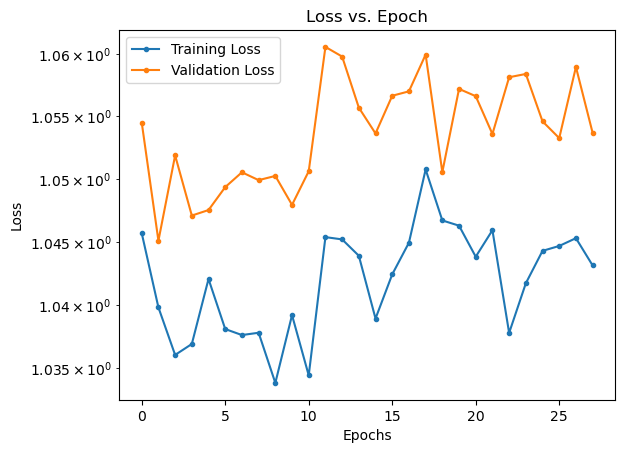

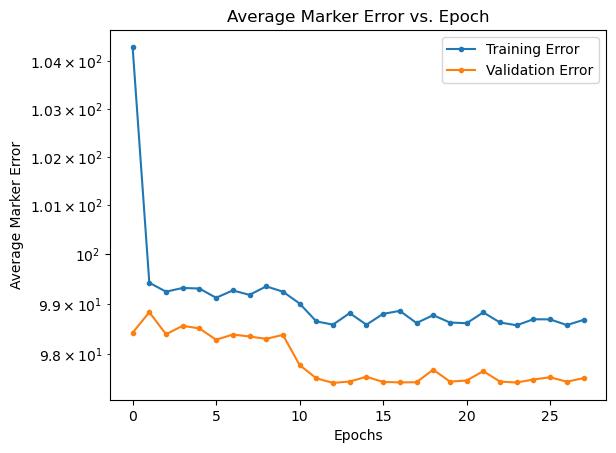

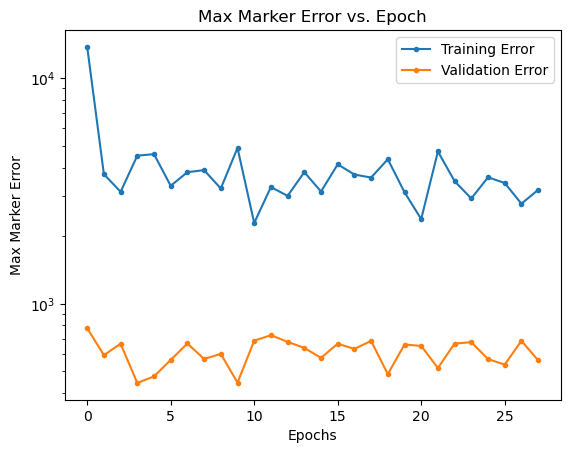

In [7]:
plt.plot(metrics['Training Loss'], label = 'Training Loss', marker = '.')
plt.plot(metrics['Validation Loss'], label = 'Validation Loss', marker = '.')
plt.yscale('log')
plt.title('Loss vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(metrics['Training Avg Marker Error'], label = 'Training Error', marker = '.')
plt.plot(metrics['Validation Avg Marker Error'], label = 'Validation Error', marker = '.')
plt.yscale('log')
plt.title('Average Marker Error vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Average Marker Error')
plt.legend()
plt.show()

plt.plot(metrics['Training Max Marker Error'], label = 'Training Error', marker = '.')
plt.plot(metrics['Validation Max Marker Error'], label = 'Validation Error', marker = '.')
plt.yscale('log')
plt.title('Max Marker Error vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Max Marker Error')
plt.legend()
plt.show()